## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import json 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [3]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [4]:
df_train = pd.read_csv("../../data/train/geno/geno_klek_train.csv")
df_test = pd.read_csv("../../data/train/geno/geno_klek_test.csv")
df_valid = pd.read_csv("../../data/train/geno/geno_klek_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [5]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'genotoxicity']
y_train_all = df_train_all['genotoxicity']

X_train = df_train.loc[:, df_train.columns != 'genotoxicity']
y_train = df_train['genotoxicity']

X_test = df_test.loc[:, df_test.columns != 'genotoxicity']
y_test = df_test['genotoxicity']

X_valid = df_valid.loc[:, df_valid.columns != 'genotoxicity']
y_valid = df_valid['genotoxicity']

In [6]:
with open('../../klek_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train_all = X_train_all[idxs['genotoxicity']]
X_train = X_train[idxs['genotoxicity']]
X_test = X_test[idxs['genotoxicity']]
X_valid = X_valid[idxs['genotoxicity']]

In [7]:
X_train.shape

(17440, 571)

In [8]:
X_test.shape

(4984, 571)

In [9]:
X_valid.shape

(2491, 571)

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [10]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(571, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [11]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [12]:
best_value = 1
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=2491, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 1.9530752989130282, Accuracy: -8.382603382705993
Test Avg. loss: 1.552111268043518, Accuracy: -5.4838571329068575
################## EPOCH 2 ##################
Train Avg. loss: 1.4724642908901249, Accuracy: -6.213145529202603
Test Avg. loss: 0.6679298877716064, Accuracy: -1.7902395157361384
################## EPOCH 3 ##################
Train Avg. loss: 1.2424074999783017, Accuracy: -5.118976349281961
Test Avg. loss: 0.48258161544799805, Accuracy: -1.015957553973085
################## EPOCH 4 ##################
Train Avg. loss: 1.0927717709760054, Accuracy: -4.347133355859922
Test Avg. loss: 0.5195630788803101, Accuracy: -1.170445348744813
################## EPOCH 5 ##################
Train Avg. loss: 0.9473513988179898, Accuracy: -3.561311408062058
Test Avg. loss: 0.3557330369949341, Accuracy: -0.48605464642120055
################## EPOCH 6 ##################
Train Avg. loss: 0.814446713016667

Train Avg. loss: 0.115708363404788, Accuracy: 0.46724599207212036
Test Avg. loss: 0.19635875523090363, Accuracy: 0.1797223371828106
################## EPOCH 48 ##################
Train Avg. loss: 0.11187268727963123, Accuracy: 0.48263881842724665
Test Avg. loss: 0.19694378972053528, Accuracy: 0.17727847848660472
################## EPOCH 49 ##################
Train Avg. loss: 0.11398028076857054, Accuracy: 0.4710331220033785
Test Avg. loss: 0.19198288023471832, Accuracy: 0.19800232531407458
################## EPOCH 50 ##################
Train Avg. loss: 0.11242319813015264, Accuracy: 0.48398124404810466
Test Avg. loss: 0.19818104803562164, Accuracy: 0.17210980767410133
################## EPOCH 51 ##################
Train Avg. loss: 0.11110326387329933, Accuracy: 0.4851439828753138
Test Avg. loss: 0.19593343138694763, Accuracy: 0.18149912224666465
################## EPOCH 52 ##################
Train Avg. loss: 0.11146930790754087, Accuracy: 0.48035299485020166
Test Avg. loss: 0.196319669

Train Avg. loss: 0.08459825653480281, Accuracy: 0.6069792559722357
Test Avg. loss: 0.19667239487171173, Accuracy: 0.1784121333370895
################## EPOCH 94 ##################
Train Avg. loss: 0.08335091832239147, Accuracy: 0.6119418729008034
Test Avg. loss: 0.1921623945236206, Accuracy: 0.19725246008694197
################## EPOCH 95 ##################
Train Avg. loss: 0.08263536312984764, Accuracy: 0.6129862795658161
Test Avg. loss: 0.1962662786245346, Accuracy: 0.1801087014617222
################## EPOCH 96 ##################
Train Avg. loss: 0.08253518878525003, Accuracy: 0.618443461717249
Test Avg. loss: 0.1951308697462082, Accuracy: 0.18485178665603774
################## EPOCH 97 ##################
Train Avg. loss: 0.08189982313218466, Accuracy: 0.6189802690215345
Test Avg. loss: 0.19496147334575653, Accuracy: 0.1855594822951232
################## EPOCH 98 ##################
Train Avg. loss: 0.08325514783142904, Accuracy: 0.6119986316542386
Test Avg. loss: 0.193328857421875, 

Train Avg. loss: 0.07161874559904458, Accuracy: 0.6628949277153007
Test Avg. loss: 0.19645266234874725, Accuracy: 0.17933007684976843
################## EPOCH 140 ##################
Train Avg. loss: 0.07032534343387009, Accuracy: 0.6753005627332819
Test Avg. loss: 0.19690191745758057, Accuracy: 0.1774533329062704
################## EPOCH 141 ##################
Train Avg. loss: 0.07191457187568923, Accuracy: 0.6633985465867256
Test Avg. loss: 0.19537357985973358, Accuracy: 0.18383787056746237
################## EPOCH 142 ##################
Train Avg. loss: 0.07258747516011974, Accuracy: 0.6661280729438332
Test Avg. loss: 0.19394125044345856, Accuracy: 0.18982132352187264
################## EPOCH 143 ##################
Train Avg. loss: 0.07002593229670043, Accuracy: 0.6686261007563628
Test Avg. loss: 0.1915162205696106, Accuracy: 0.19995171950640966
################## EPOCH 144 ##################
Train Avg. loss: 0.06871372952100334, Accuracy: 0.6786807613169197
Test Avg. loss: 0.1922339

Train Avg. loss: 0.0640366109327302, Accuracy: 0.7043501057873622
Test Avg. loss: 0.19412213563919067, Accuracy: 0.1890657208418297
################## EPOCH 186 ##################
Train Avg. loss: 0.0639358867369934, Accuracy: 0.702840974137511
Test Avg. loss: 0.19295571744441986, Accuracy: 0.1939383401057969
################## EPOCH 187 ##################
Train Avg. loss: 0.06173017906759857, Accuracy: 0.7120750227360597
Test Avg. loss: 0.19454163312911987, Accuracy: 0.1873133189996241
################## EPOCH 188 ##################
Train Avg. loss: 0.0615372089549489, Accuracy: 0.7119762920499241
Test Avg. loss: 0.19334742426872253, Accuracy: 0.19230202425018572
################## EPOCH 189 ##################
Train Avg. loss: 0.06564086502024886, Accuracy: 0.6957155561348795
Test Avg. loss: 0.19477546215057373, Accuracy: 0.18633650498859178
################## EPOCH 190 ##################
Train Avg. loss: 0.06316375245741748, Accuracy: 0.7038778445496254
Test Avg. loss: 0.196560889482

Train Avg. loss: 0.057872181652335944, Accuracy: 0.72971848742318
Test Avg. loss: 0.1969033181667328, Accuracy: 0.1774474355162653
################## EPOCH 232 ##################
Train Avg. loss: 0.05940247943641942, Accuracy: 0.7247513539547875
Test Avg. loss: 0.193581223487854, Accuracy: 0.19132533454499057
################## EPOCH 233 ##################
Train Avg. loss: 0.05685023579302184, Accuracy: 0.7340553773730308
Test Avg. loss: 0.1964724212884903, Accuracy: 0.17924752153809953
################## EPOCH 234 ##################
Train Avg. loss: 0.05673956268150872, Accuracy: 0.734487750754773
Test Avg. loss: 0.1961991786956787, Accuracy: 0.18038900199110897
################## EPOCH 235 ##################
Train Avg. loss: 0.05689570321744188, Accuracy: 0.7322698593028295
Test Avg. loss: 0.19658413529396057, Accuracy: 0.1787808981832789
################## EPOCH 236 ##################
Train Avg. loss: 0.05725407302037838, Accuracy: 0.7312257476164741
Test Avg. loss: 0.19577386975288

Train Avg. loss: 0.05435770847791926, Accuracy: 0.7451851642181628
Test Avg. loss: 0.19662630558013916, Accuracy: 0.17860462448864778
################## EPOCH 278 ##################
Train Avg. loss: 0.05490180877370572, Accuracy: 0.7417730954294223
Test Avg. loss: 0.19293446838855743, Accuracy: 0.19402713921893755
################## EPOCH 279 ##################
Train Avg. loss: 0.0538154798158265, Accuracy: 0.749633467641792
Test Avg. loss: 0.19616413116455078, Accuracy: 0.18053537193002267
################## EPOCH 280 ##################
Train Avg. loss: 0.051744490164682404, Accuracy: 0.7557647529016323
Test Avg. loss: 0.19811208546161652, Accuracy: 0.17239788730253303
################## EPOCH 281 ##################
Train Avg. loss: 0.05445543369705524, Accuracy: 0.7434018389285303
Test Avg. loss: 0.19914518296718597, Accuracy: 0.16808224574256836
################## EPOCH 282 ##################
Train Avg. loss: 0.053341229403511096, Accuracy: 0.7528328547463531
Test Avg. loss: 0.19894

Train Avg. loss: 0.28992782363961467, Accuracy: -0.2579312949910709
Test Avg. loss: 0.20095255970954895, Accuracy: 0.16053205169144258
################## EPOCH 24 ##################
Train Avg. loss: 0.27291132307751276, Accuracy: -0.17367028113856578
Test Avg. loss: 0.20175747573375702, Accuracy: 0.15716953864616268
################## EPOCH 25 ##################
Train Avg. loss: 0.25793238813842173, Accuracy: -0.1141023131525124
Test Avg. loss: 0.19481052458286285, Accuracy: 0.18619000310690115
################## EPOCH 26 ##################
Train Avg. loss: 0.24149651260493876, Accuracy: -0.03659502208415406
Test Avg. loss: 0.19747038185596466, Accuracy: 0.17507855306861675
################## EPOCH 27 ##################
Train Avg. loss: 0.2304251857729622, Accuracy: 0.008341727263457166
Test Avg. loss: 0.19531406462192535, Accuracy: 0.18408645829515113
################## EPOCH 28 ##################
Train Avg. loss: 0.21753201128798963, Accuracy: 0.06938237622238776
Test Avg. loss: 0.19

Train Avg. loss: 0.09328007955963795, Accuracy: 0.5906356278530999
Test Avg. loss: 0.19764591753482819, Accuracy: 0.17434526617916613
################## EPOCH 70 ##################
Train Avg. loss: 0.09282814412490352, Accuracy: 0.5991212826799637
Test Avg. loss: 0.1952933669090271, Accuracy: 0.18417303582636646
################## EPOCH 71 ##################
Train Avg. loss: 0.09131785229721785, Accuracy: 0.6050561191087749
Test Avg. loss: 0.19377513229846954, Accuracy: 0.19051535837842737
################## EPOCH 72 ##################
Train Avg. loss: 0.09233001387599624, Accuracy: 0.6012787218994501
Test Avg. loss: 0.1963644176721573, Accuracy: 0.17969869332195498
################## EPOCH 73 ##################
Train Avg. loss: 0.08896108749476107, Accuracy: 0.6121074221570657
Test Avg. loss: 0.19552835822105408, Accuracy: 0.18319125053880891
################## EPOCH 74 ##################
Train Avg. loss: 0.09160412886203864, Accuracy: 0.5989768898076553
Test Avg. loss: 0.194873571395

Train Avg. loss: 0.07272253076344619, Accuracy: 0.6843121607178552
Test Avg. loss: 0.19275005161762238, Accuracy: 0.1947974859028837
################## EPOCH 116 ##################
Train Avg. loss: 0.07355396910110018, Accuracy: 0.6840911700139463
Test Avg. loss: 0.19482587277889252, Accuracy: 0.18612581845186893
################## EPOCH 117 ##################
Train Avg. loss: 0.07553729810666689, Accuracy: 0.6730650681399108
Test Avg. loss: 0.19277921319007874, Accuracy: 0.19467565883132343
################## EPOCH 118 ##################
Train Avg. loss: 0.07299938007861703, Accuracy: 0.681322423763759
Test Avg. loss: 0.19392235577106476, Accuracy: 0.18990021816428493
################## EPOCH 119 ##################
Train Avg. loss: 0.07192725325924354, Accuracy: 0.6848209409981572
Test Avg. loss: 0.19272646307945251, Accuracy: 0.19489606799947345
################## EPOCH 120 ##################
Train Avg. loss: 0.07041938463737676, Accuracy: 0.6910488625398058
Test Avg. loss: 0.1924467

Train Avg. loss: 0.061380219035150806, Accuracy: 0.7317838081063402
Test Avg. loss: 0.19215945899486542, Accuracy: 0.19726463375316483
################## EPOCH 162 ##################
Train Avg. loss: 0.06250615080907232, Accuracy: 0.729633592038527
Test Avg. loss: 0.19313861429691315, Accuracy: 0.1931742555988022
################## EPOCH 163 ##################
Train Avg. loss: 0.06042739181291489, Accuracy: 0.7368004368946985
Test Avg. loss: 0.19518624246120453, Accuracy: 0.18462048569820833
################## EPOCH 164 ##################
Train Avg. loss: 0.06073690978162018, Accuracy: 0.7365221751259989
Test Avg. loss: 0.19219495356082916, Accuracy: 0.19711641445316708
################## EPOCH 165 ##################
Train Avg. loss: 0.060332629099597426, Accuracy: 0.737940773718422
Test Avg. loss: 0.19482028484344482, Accuracy: 0.18614927687278582
################## EPOCH 166 ##################
Train Avg. loss: 0.06093427889567592, Accuracy: 0.7355287918079194
Test Avg. loss: 0.195200

Train Avg. loss: 0.055180608168681027, Accuracy: 0.7606180608027413
Test Avg. loss: 0.1937120109796524, Accuracy: 0.19077899804075438
################## EPOCH 208 ##################
Train Avg. loss: 0.05536878011411145, Accuracy: 0.7581291194721946
Test Avg. loss: 0.19575530290603638, Accuracy: 0.18224323382095386
################## EPOCH 209 ##################
Train Avg. loss: 0.05444840324066934, Accuracy: 0.7634355915074957
Test Avg. loss: 0.19408974051475525, Accuracy: 0.18920105123240816
################## EPOCH 210 ##################
Train Avg. loss: 0.054771697182795065, Accuracy: 0.7594224536800328
Test Avg. loss: 0.19556516408920288, Accuracy: 0.18303750961157883
################## EPOCH 211 ##################
Train Avg. loss: 0.05553442653227639, Accuracy: 0.757063072804653
Test Avg. loss: 0.19518205523490906, Accuracy: 0.1846378852514976
################## EPOCH 212 ##################
Train Avg. loss: 0.05395174607116006, Accuracy: 0.7632232974828129
Test Avg. loss: 0.193661

Train Avg. loss: 0.053144522195497715, Accuracy: 0.7681800511797923
Test Avg. loss: 0.19460931420326233, Accuracy: 0.1870305562136193
################## EPOCH 254 ##################
Train Avg. loss: 0.052205819554708814, Accuracy: 0.7731231618401334
Test Avg. loss: 0.19754372537136078, Accuracy: 0.17477220839282948
################## EPOCH 255 ##################
Train Avg. loss: 0.05240522896795919, Accuracy: 0.7743957433810159
Test Avg. loss: 0.1951211392879486, Accuracy: 0.18489251402927442
################## EPOCH 256 ##################
Train Avg. loss: 0.04878519569615741, Accuracy: 0.7867816968982813
Test Avg. loss: 0.19720718264579773, Accuracy: 0.17617808934171653
################## EPOCH 257 ##################
Train Avg. loss: 0.0515445334761789, Accuracy: 0.7751732786256457
Test Avg. loss: 0.19430404901504517, Accuracy: 0.18830576579784775
################## EPOCH 258 ##################
Train Avg. loss: 0.05032077720286427, Accuracy: 0.7807625300360066
Test Avg. loss: 0.195344

Train Avg. loss: 0.047693828925927044, Accuracy: 0.7924566135392253
Test Avg. loss: 0.1986326426267624, Accuracy: 0.1702233446143021
################## EPOCH 300 ##################
Train Avg. loss: 0.0480462397779628, Accuracy: 0.7908964846502862
Test Avg. loss: 0.19653844833374023, Accuracy: 0.1789717108604486
Model: lr 0.001, batch_size 128
################## EPOCH 1 ##################
Train Avg. loss: 2.1738608988532184, Accuracy: -8.097875590081367
Test Avg. loss: 1.1771883964538574, Accuracy: -3.9176381888313596
################## EPOCH 2 ##################
Train Avg. loss: 1.3166083515125468, Accuracy: -4.687059494419601
Test Avg. loss: 1.0882413387298584, Accuracy: -3.5460665864527314
################## EPOCH 3 ##################
Train Avg. loss: 1.2431979423021748, Accuracy: -4.370998431701499
Test Avg. loss: 1.0929075479507446, Accuracy: -3.565560023312626
################## EPOCH 4 ##################
Train Avg. loss: 1.2371876422506178, Accuracy: -4.321204949127032
Test Avg. 

Train Avg. loss: 0.25435974769783715, Accuracy: -0.08705122564677634
Test Avg. loss: 0.19805146753787994, Accuracy: 0.1726510951421033
################## EPOCH 46 ##################
Train Avg. loss: 0.24504326642864813, Accuracy: -0.044939780540731104
Test Avg. loss: 0.2028898149728775, Accuracy: 0.1524392273433619
################## EPOCH 47 ##################
Train Avg. loss: 0.2355242547762655, Accuracy: -0.002361236077048371
Test Avg. loss: 0.1967715620994568, Accuracy: 0.1779979223457432
################## EPOCH 48 ##################
Train Avg. loss: 0.22347496863264238, Accuracy: 0.04978137534200865
Test Avg. loss: 0.19610658288002014, Accuracy: 0.18077584140139147
################## EPOCH 49 ##################
Train Avg. loss: 0.2197502819943602, Accuracy: 0.06693665220944164
Test Avg. loss: 0.20106546580791473, Accuracy: 0.16006031391928488
################## EPOCH 50 ##################
Train Avg. loss: 0.20901324659803489, Accuracy: 0.11031917410537842
Test Avg. loss: 0.196401

Train Avg. loss: 0.08392910735450522, Accuracy: 0.6422537408867076
Test Avg. loss: 0.19210417568683624, Accuracy: 0.19749562351785943
################## EPOCH 92 ##################
Train Avg. loss: 0.08364201339818265, Accuracy: 0.6455958748489186
Test Avg. loss: 0.1941642016172409, Accuracy: 0.18889000778825582
################## EPOCH 93 ##################
Train Avg. loss: 0.08205314453718436, Accuracy: 0.6517890336429879
Test Avg. loss: 0.18946127593517303, Accuracy: 0.20853616484880888
################## EPOCH 94 ##################
Train Avg. loss: 0.08355202210428071, Accuracy: 0.6445324825025414
Test Avg. loss: 0.19082313776016235, Accuracy: 0.2028470849773465
################## EPOCH 95 ##################
Train Avg. loss: 0.0833759605612633, Accuracy: 0.644452026179501
Test Avg. loss: 0.1911214143037796, Accuracy: 0.2016010062374639
################## EPOCH 96 ##################
Train Avg. loss: 0.08031459022177397, Accuracy: 0.6580177465120273
Test Avg. loss: 0.1903304159641266

Train Avg. loss: 0.06624037530409159, Accuracy: 0.7182668882035563
Test Avg. loss: 0.19076822698116302, Accuracy: 0.2030764562731321
################## EPOCH 138 ##################
Train Avg. loss: 0.06722558072231112, Accuracy: 0.715106371080242
Test Avg. loss: 0.19376157224178314, Accuracy: 0.1905719091364021
################## EPOCH 139 ##################
Train Avg. loss: 0.06626748728708629, Accuracy: 0.7168076610859144
Test Avg. loss: 0.19023001194000244, Accuracy: 0.2053247716949519
################## EPOCH 140 ##################
Train Avg. loss: 0.06469521239182374, Accuracy: 0.7266390161230704
Test Avg. loss: 0.18957887589931488, Accuracy: 0.20804489984109753
################## EPOCH 141 ##################
Train Avg. loss: 0.06518712509287534, Accuracy: 0.7240748776410092
Test Avg. loss: 0.19386370480060577, Accuracy: 0.19014537149957977
################## EPOCH 142 ##################
Train Avg. loss: 0.06340591503429586, Accuracy: 0.7302951298021533
Test Avg. loss: 0.193559631

Train Avg. loss: 0.05727158843056999, Accuracy: 0.7566670902576162
Test Avg. loss: 0.19328436255455017, Accuracy: 0.19256551760552354
################## EPOCH 184 ##################
Train Avg. loss: 0.05617604075665891, Accuracy: 0.7600501067595993
Test Avg. loss: 0.1998545080423355, Accuracy: 0.16511904669308897
################## EPOCH 185 ##################
Train Avg. loss: 0.05704143763023571, Accuracy: 0.7580262925737234
Test Avg. loss: 0.193258136510849, Accuracy: 0.1926750119505678
################## EPOCH 186 ##################
Train Avg. loss: 0.05699843929631867, Accuracy: 0.7580793395872094
Test Avg. loss: 0.19244438409805298, Accuracy: 0.19607443677842185
################## EPOCH 187 ##################
Train Avg. loss: 0.05558847659097536, Accuracy: 0.7637873397612172
Test Avg. loss: 0.1966971904039383, Accuracy: 0.17830856614284862
################## EPOCH 188 ##################
Train Avg. loss: 0.057510757370151745, Accuracy: 0.7546650756475092
Test Avg. loss: 0.189256176

Train Avg. loss: 0.051649996018322715, Accuracy: 0.7815974586195065
Test Avg. loss: 0.19324710965156555, Accuracy: 0.19272110926831587
################## EPOCH 230 ##################
Train Avg. loss: 0.0506783129960081, Accuracy: 0.7848240217873549
Test Avg. loss: 0.19615565240383148, Accuracy: 0.18057083069162505
################## EPOCH 231 ##################
Train Avg. loss: 0.05133471181140329, Accuracy: 0.7843056237125977
Test Avg. loss: 0.19414469599723816, Accuracy: 0.18897145161229223
################## EPOCH 232 ##################
Train Avg. loss: 0.05143743094029653, Accuracy: 0.7819072398852751
Test Avg. loss: 0.19853098690509796, Accuracy: 0.1706479921600167
################## EPOCH 233 ##################
Train Avg. loss: 0.05247056467907272, Accuracy: 0.7772331118790441
Test Avg. loss: 0.19748148322105408, Accuracy: 0.17503219782207824
################## EPOCH 234 ##################
Train Avg. loss: 0.05226554332749687, Accuracy: 0.7775528235456609
Test Avg. loss: 0.189913

Train Avg. loss: 0.04645337360183688, Accuracy: 0.8031612829337935
Test Avg. loss: 0.19267475605010986, Accuracy: 0.19511206774377465
################## EPOCH 276 ##################
Train Avg. loss: 0.04714016578275792, Accuracy: 0.7988462479804141
Test Avg. loss: 0.19741560518741608, Accuracy: 0.17530745650127466
################## EPOCH 277 ##################
Train Avg. loss: 0.047026031276714196, Accuracy: 0.7999212835086555
Test Avg. loss: 0.1947634220123291, Accuracy: 0.18638673398883976
################## EPOCH 278 ##################
Train Avg. loss: 0.04748258667651319, Accuracy: 0.7987167620508178
Test Avg. loss: 0.19348308444023132, Accuracy: 0.19173528605103596
################## EPOCH 279 ##################
Train Avg. loss: 0.04647335373409038, Accuracy: 0.8020212464733709
Test Avg. loss: 0.19367004930973053, Accuracy: 0.1909542690641185
################## EPOCH 280 ##################
Train Avg. loss: 0.04805348877434748, Accuracy: 0.7959265071812172
Test Avg. loss: 0.192258

Train Avg. loss: 1.1015809791675513, Accuracy: -3.6427527324570894
Test Avg. loss: 0.49484774470329285, Accuracy: -1.0671985773409882
################## EPOCH 22 ##################
Train Avg. loss: 1.0805886405101721, Accuracy: -3.563086730151126
Test Avg. loss: 0.5512304902076721, Accuracy: -1.3027342656407805
################## EPOCH 23 ##################
Train Avg. loss: 1.0720312318940093, Accuracy: -3.5418044374728197
Test Avg. loss: 0.49318835139274597, Accuracy: -1.060266761831484
################## EPOCH 24 ##################
Train Avg. loss: 1.0221871206725852, Accuracy: -3.300624028547082
Test Avg. loss: 0.5479598641395569, Accuracy: -1.2890715344922667
################## EPOCH 25 ##################
Train Avg. loss: 1.0107992196428603, Accuracy: -3.26467925479848
Test Avg. loss: 0.5031930208206177, Accuracy: -1.1020605282872191
################## EPOCH 26 ##################
Train Avg. loss: 0.9839624140573584, Accuracy: -3.1530603837968583
Test Avg. loss: 0.4170761704444885, 

Train Avg. loss: 0.34408942685611005, Accuracy: -0.4469834977280346
Test Avg. loss: 0.2160630077123642, Accuracy: 0.0974089640010809
################## EPOCH 68 ##################
Train Avg. loss: 0.3385414347268533, Accuracy: -0.42229074882281464
Test Avg. loss: 0.21305502951145172, Accuracy: 0.10997459344879934
################## EPOCH 69 ##################
Train Avg. loss: 0.31963049825550854, Accuracy: -0.33927464434759963
Test Avg. loss: 0.21176591515541077, Accuracy: 0.11535977918930918
################## EPOCH 70 ##################
Train Avg. loss: 0.3088345873183098, Accuracy: -0.29342349308215016
Test Avg. loss: 0.2255229651927948, Accuracy: 0.05789049063619611
################## EPOCH 71 ##################
Train Avg. loss: 0.3049629600583643, Accuracy: -0.2788802436110913
Test Avg. loss: 0.22330540418624878, Accuracy: 0.06715430960192792
################## EPOCH 72 ##################
Train Avg. loss: 0.2921521415313085, Accuracy: -0.2245010731392806
Test Avg. loss: 0.20887644

Train Avg. loss: 0.1019457546805126, Accuracy: 0.5737727345011531
Test Avg. loss: 0.19366803765296936, Accuracy: 0.19096265648144606
################## EPOCH 114 ##################
Train Avg. loss: 0.09597904326907103, Accuracy: 0.5984888577136531
Test Avg. loss: 0.19179992377758026, Accuracy: 0.19876658257780544
################## EPOCH 115 ##################
Train Avg. loss: 0.09682035629732022, Accuracy: 0.5949756440559523
Test Avg. loss: 0.18944114446640015, Accuracy: 0.20862029140883243
################## EPOCH 116 ##################
Train Avg. loss: 0.09762918571199196, Accuracy: 0.5927421214727049
Test Avg. loss: 0.19249767065048218, Accuracy: 0.19585180225332222
################## EPOCH 117 ##################
Train Avg. loss: 0.0929822825651238, Accuracy: 0.6115675118108839
Test Avg. loss: 0.19261164963245392, Accuracy: 0.19537571866366077
################## EPOCH 118 ##################
Train Avg. loss: 0.09245915257412454, Accuracy: 0.6145574384436806
Test Avg. loss: 0.1928265

Train Avg. loss: 0.06889541922272116, Accuracy: 0.7121933255223375
Test Avg. loss: 0.19604600965976715, Accuracy: 0.1810288269882352
################## EPOCH 160 ##################
Train Avg. loss: 0.07318483795160832, Accuracy: 0.6937625358705648
Test Avg. loss: 0.20387224853038788, Accuracy: 0.14833514497273803
################## EPOCH 161 ##################
Train Avg. loss: 0.06907671171685924, Accuracy: 0.7108238840115904
Test Avg. loss: 0.18775075674057007, Accuracy: 0.21568178162346252
################## EPOCH 162 ##################
Train Avg. loss: 0.07040005528192589, Accuracy: 0.7064651420525272
Test Avg. loss: 0.19347642362117767, Accuracy: 0.1917631499619894
################## EPOCH 163 ##################
Train Avg. loss: 0.07101983398846957, Accuracy: 0.7023105440967403
Test Avg. loss: 0.19498583674430847, Accuracy: 0.18545763329640585
################## EPOCH 164 ##################
Train Avg. loss: 0.07017981698331625, Accuracy: 0.7082454876468968
Test Avg. loss: 0.1969022

Train Avg. loss: 0.062297003046757934, Accuracy: 0.740131029098204
Test Avg. loss: 0.19525589048862457, Accuracy: 0.18432949536545573
################## EPOCH 206 ##################
Train Avg. loss: 0.062356999224942665, Accuracy: 0.7385064536468117
Test Avg. loss: 0.19164583086967468, Accuracy: 0.19941030650645575
################## EPOCH 207 ##################
Train Avg. loss: 0.06117499765494595, Accuracy: 0.7440219439978051
Test Avg. loss: 0.19253197312355042, Accuracy: 0.1957084936014276
################## EPOCH 208 ##################
Train Avg. loss: 0.06403452951623045, Accuracy: 0.7328334443864513
Test Avg. loss: 0.19098326563835144, Accuracy: 0.2021781022031176
################## EPOCH 209 ##################
Train Avg. loss: 0.061332950665467026, Accuracy: 0.7429283991073995
Test Avg. loss: 0.1898888498544693, Accuracy: 0.2067499934576824
################## EPOCH 210 ##################
Train Avg. loss: 0.06138143931394038, Accuracy: 0.7440086480301346
Test Avg. loss: 0.1929480

Train Avg. loss: 0.05680160251432571, Accuracy: 0.7627141972146882
Test Avg. loss: 0.1860254853963852, Accuracy: 0.22288899680960272
################## EPOCH 252 ##################
Train Avg. loss: 0.05644713379982589, Accuracy: 0.7645136948029144
Test Avg. loss: 0.18491753935813904, Accuracy: 0.2275173833021118
################## EPOCH 253 ##################
Train Avg. loss: 0.055866566041241524, Accuracy: 0.7664105833934666
Test Avg. loss: 0.1891217976808548, Accuracy: 0.20995434878584718
################## EPOCH 254 ##################
Train Avg. loss: 0.054330386221408844, Accuracy: 0.7735011134534091
Test Avg. loss: 0.1872231662273407, Accuracy: 0.21788580218246
################## EPOCH 255 ##################
Train Avg. loss: 0.05549654143228047, Accuracy: 0.7682451015232425
Test Avg. loss: 0.18878969550132751, Accuracy: 0.21134168758122307
################## EPOCH 256 ##################
Train Avg. loss: 0.054485852870604264, Accuracy: 0.7721242333922702
Test Avg. loss: 0.192299157

Train Avg. loss: 0.051941661947015404, Accuracy: 0.7841613244178386
Test Avg. loss: 0.19086404144763947, Accuracy: 0.20267624260947026
################## EPOCH 298 ##################
Train Avg. loss: 0.05171968733918839, Accuracy: 0.7841932129543352
Test Avg. loss: 0.1897961050271988, Accuracy: 0.20713742244374989
################## EPOCH 299 ##################
Train Avg. loss: 0.05260954381547112, Accuracy: 0.7806688660350367
Test Avg. loss: 0.18922674655914307, Accuracy: 0.20951596357273883
################## EPOCH 300 ##################
Train Avg. loss: 0.05274342826527098, Accuracy: 0.7794492844753739
Test Avg. loss: 0.1879771649837494, Accuracy: 0.2147359666693499
Model: lr 0.005, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 1.980280851989711, Accuracy: -8.605506262235853
Test Avg. loss: 0.43094402551651, Accuracy: -0.8002443543391085
################## EPOCH 2 ##################
Train Avg. loss: 0.9448752620351424, Accuracy: -3.5871211670462997
Tes

Train Avg. loss: 0.20105613182990922, Accuracy: 0.11812630531203924
Test Avg. loss: 0.20924581587314606, Accuracy: 0.12588746629403647
################## EPOCH 44 ##################
Train Avg. loss: 0.19820075627040426, Accuracy: 0.13450768763269055
Test Avg. loss: 0.20792803168296814, Accuracy: 0.13139239175795114
################## EPOCH 45 ##################
Train Avg. loss: 0.19751337232119445, Accuracy: 0.13068843392914908
Test Avg. loss: 0.21323169767856598, Accuracy: 0.10923656454705111
################## EPOCH 46 ##################
Train Avg. loss: 0.19752670112279577, Accuracy: 0.1341653016652908
Test Avg. loss: 0.21723777055740356, Accuracy: 0.0925014872670552
################## EPOCH 47 ##################
Train Avg. loss: 0.1962162298483586, Accuracy: 0.14409470224178378
Test Avg. loss: 0.20819811522960663, Accuracy: 0.1302641315355384
################## EPOCH 48 ##################
Train Avg. loss: 0.19164902813254148, Accuracy: 0.1592713351905575
Test Avg. loss: 0.206744760

Train Avg. loss: 0.16777186378699924, Accuracy: 0.2603436374905771
Test Avg. loss: 0.2000904232263565, Accuracy: 0.1641335888947364
################## EPOCH 90 ##################
Train Avg. loss: 0.16593072220272975, Accuracy: 0.26824739700251227
Test Avg. loss: 0.2080272138118744, Accuracy: 0.13097799326484605
################## EPOCH 91 ##################
Train Avg. loss: 0.16725939347519786, Accuracy: 0.26105051042509253
Test Avg. loss: 0.2054828405380249, Accuracy: 0.14160698061918486
################## EPOCH 92 ##################
Train Avg. loss: 0.16606124396854585, Accuracy: 0.26511602171279647
Test Avg. loss: 0.20373879373073578, Accuracy: 0.14889270086180417
################## EPOCH 93 ##################
Train Avg. loss: 0.1637249813372389, Accuracy: 0.27322043109159544
Test Avg. loss: 0.20587919652462006, Accuracy: 0.13995119934416467
################## EPOCH 94 ##################
Train Avg. loss: 0.16530400506400186, Accuracy: 0.2699226858473802
Test Avg. loss: 0.20606911182

Train Avg. loss: 0.15567522392087027, Accuracy: 0.3069021147071242
Test Avg. loss: 0.20723387598991394, Accuracy: 0.13429213985107868
################## EPOCH 136 ##################
Train Avg. loss: 0.15687346878811853, Accuracy: 0.3046121431096848
Test Avg. loss: 0.2061997950077057, Accuracy: 0.13861190991092298
################## EPOCH 137 ##################
Train Avg. loss: 0.15483886713008269, Accuracy: 0.31213198400579556
Test Avg. loss: 0.19899089634418488, Accuracy: 0.1687267297364673
################## EPOCH 138 ##################
Train Avg. loss: 0.15283014779790827, Accuracy: 0.32027309649756386
Test Avg. loss: 0.20367155969142914, Accuracy: 0.14917349296857718
################## EPOCH 139 ##################
Train Avg. loss: 0.15269392448554345, Accuracy: 0.3221412216175605
Test Avg. loss: 0.2043607085943222, Accuracy: 0.14629469680613805
################## EPOCH 140 ##################
Train Avg. loss: 0.1590959196380519, Accuracy: 0.29179481932302337
Test Avg. loss: 0.203830

Train Avg. loss: 0.1446896987428906, Accuracy: 0.35788670908454584
Test Avg. loss: 0.2020457535982132, Accuracy: 0.15596526499009344
################## EPOCH 182 ##################
Train Avg. loss: 0.14680350996348837, Accuracy: 0.3531020215744637
Test Avg. loss: 0.20030643045902252, Accuracy: 0.16323115710757985
################## EPOCH 183 ##################
Train Avg. loss: 0.1430843756491438, Accuracy: 0.36239138610113447
Test Avg. loss: 0.20267903804779053, Accuracy: 0.15331974402030135
################## EPOCH 184 ##################
Train Avg. loss: 0.14362830952356714, Accuracy: 0.36135957298043403
Test Avg. loss: 0.20258352160453796, Accuracy: 0.15371871509761947
################## EPOCH 185 ##################
Train Avg. loss: 0.14424917785399552, Accuracy: 0.358999560444389
Test Avg. loss: 0.19929014146327972, Accuracy: 0.16747662563496168
################## EPOCH 186 ##################
Train Avg. loss: 0.14651329672527968, Accuracy: 0.3470341643497477
Test Avg. loss: 0.202418

Train Avg. loss: 0.1456423525348169, Accuracy: 0.3515165542871218
Test Avg. loss: 0.20278260111808777, Accuracy: 0.15288703403032977
################## EPOCH 228 ##################
Train Avg. loss: 0.14037528904069455, Accuracy: 0.37707905345627596
Test Avg. loss: 0.2037213295698166, Accuracy: 0.14896562071217712
################## EPOCH 229 ##################
Train Avg. loss: 0.14081855567360144, Accuracy: 0.37381487419713433
Test Avg. loss: 0.20134775340557098, Accuracy: 0.15888107846835609
################## EPOCH 230 ##################
Train Avg. loss: 0.14106603101442713, Accuracy: 0.3708962650839784
Test Avg. loss: 0.19964343309402466, Accuracy: 0.1660007949686816
################## EPOCH 231 ##################
Train Avg. loss: 0.1379157321237096, Accuracy: 0.3847833407981899
Test Avg. loss: 0.20041590929031372, Accuracy: 0.16277385953566537
################## EPOCH 232 ##################
Train Avg. loss: 0.14241481247024798, Accuracy: 0.36568977946621106
Test Avg. loss: 0.204685

Train Avg. loss: 0.1350528483543921, Accuracy: 0.39925316930612487
Test Avg. loss: 0.19727064669132233, Accuracy: 0.17591298014311874
################## EPOCH 274 ##################
Train Avg. loss: 0.1355617599613076, Accuracy: 0.4009731821153725
Test Avg. loss: 0.20011970400810242, Accuracy: 0.16401117847509106
################## EPOCH 275 ##################
Train Avg. loss: 0.13539590262081644, Accuracy: 0.39817839285005596
Test Avg. loss: 0.20235154032707214, Accuracy: 0.1546878546420002
################## EPOCH 276 ##################
Train Avg. loss: 0.1353241499069087, Accuracy: 0.39517415889379515
Test Avg. loss: 0.2054888904094696, Accuracy: 0.1415817601647953
################## EPOCH 277 ##################
Train Avg. loss: 0.1340882591493086, Accuracy: 0.4023374941039985
Test Avg. loss: 0.20259086787700653, Accuracy: 0.15368806281486858
################## EPOCH 278 ##################
Train Avg. loss: 0.13506565309309085, Accuracy: 0.39778913974287794
Test Avg. loss: 0.20324900

Train Avg. loss: 0.1811168480650846, Accuracy: 0.22953685679189959
Test Avg. loss: 0.19464454054832458, Accuracy: 0.18688336255430693
################## EPOCH 20 ##################
Train Avg. loss: 0.18042865837668323, Accuracy: 0.23328633882021202
Test Avg. loss: 0.19962237775325775, Accuracy: 0.1660888031156721
################## EPOCH 21 ##################
Train Avg. loss: 0.18146177525922055, Accuracy: 0.23095060802565498
Test Avg. loss: 0.20240327715873718, Accuracy: 0.15447171748374877
################## EPOCH 22 ##################
Train Avg. loss: 0.1786619355499526, Accuracy: 0.237964243773215
Test Avg. loss: 0.19769355654716492, Accuracy: 0.17414632248683037
################## EPOCH 23 ##################
Train Avg. loss: 0.17758221531307306, Accuracy: 0.24571236846851421
Test Avg. loss: 0.19823721051216125, Accuracy: 0.17187521107060488
################## EPOCH 24 ##################
Train Avg. loss: 0.1749523721171386, Accuracy: 0.25447084608801723
Test Avg. loss: 0.1993976831

Train Avg. loss: 0.12613522998251758, Accuracy: 0.45622720282941265
Test Avg. loss: 0.19706502556800842, Accuracy: 0.17677194115049444
################## EPOCH 66 ##################
Train Avg. loss: 0.1246381431626968, Accuracy: 0.46364822911916564
Test Avg. loss: 0.19953681528568268, Accuracy: 0.16644618992044136
################## EPOCH 67 ##################
Train Avg. loss: 0.12407911949596562, Accuracy: 0.4668118479399968
Test Avg. loss: 0.1906784474849701, Accuracy: 0.203451479778342
################## EPOCH 68 ##################
Train Avg. loss: 0.12318054865022282, Accuracy: 0.46758734945360425
Test Avg. loss: 0.19522152841091156, Accuracy: 0.18447305397298053
################## EPOCH 69 ##################
Train Avg. loss: 0.12209985319238442, Accuracy: 0.47586219795940704
Test Avg. loss: 0.19512657821178436, Accuracy: 0.18486976789222354
################## EPOCH 70 ##################
Train Avg. loss: 0.12427130050875329, Accuracy: 0.4649707925096096
Test Avg. loss: 0.1974172741

Train Avg. loss: 0.10572019119784509, Accuracy: 0.5459976007486881
Test Avg. loss: 0.1972779482603073, Accuracy: 0.17588246657257867
################## EPOCH 112 ##################
Train Avg. loss: 0.10551375206628125, Accuracy: 0.5458125022372768
Test Avg. loss: 0.18921034038066864, Accuracy: 0.20958444461920123
################## EPOCH 113 ##################
Train Avg. loss: 0.10236545406527571, Accuracy: 0.5558416216865011
Test Avg. loss: 0.19242718815803528, Accuracy: 0.19614626432959703
################## EPOCH 114 ##################
Train Avg. loss: 0.10272635478567291, Accuracy: 0.5580172861816112
Test Avg. loss: 0.19739313423633575, Accuracy: 0.17540131404366244
################## EPOCH 115 ##################
Train Avg. loss: 0.10347625328016369, Accuracy: 0.5528365813013421
Test Avg. loss: 0.19412261247634888, Accuracy: 0.189063802703062
################## EPOCH 116 ##################
Train Avg. loss: 0.10120530467439484, Accuracy: 0.5652397485703763
Test Avg. loss: 0.19417880

Train Avg. loss: 0.08970352048020223, Accuracy: 0.6145008078207881
Test Avg. loss: 0.19742026925086975, Accuracy: 0.17528793058776526
################## EPOCH 158 ##################
Train Avg. loss: 0.0894357742461966, Accuracy: 0.6162423614381982
Test Avg. loss: 0.20215201377868652, Accuracy: 0.15552138654068237
################## EPOCH 159 ##################
Train Avg. loss: 0.08727395930242189, Accuracy: 0.6250680811837691
Test Avg. loss: 0.19904030859470367, Accuracy: 0.16852030889623804
################## EPOCH 160 ##################
Train Avg. loss: 0.08929235179782351, Accuracy: 0.6155941898590789
Test Avg. loss: 0.19471704959869385, Accuracy: 0.18658050511811886
################## EPOCH 161 ##################
Train Avg. loss: 0.08831358470377468, Accuracy: 0.6205618118970988
Test Avg. loss: 0.19655568897724152, Accuracy: 0.17889973517000746
################## EPOCH 162 ##################
Train Avg. loss: 0.0874834663265354, Accuracy: 0.6243289899118796
Test Avg. loss: 0.1982385

Train Avg. loss: 0.08018030968559531, Accuracy: 0.6553477641907756
Test Avg. loss: 0.1981368064880371, Accuracy: 0.17229464268769812
################## EPOCH 204 ##################
Train Avg. loss: 0.08127405643190219, Accuracy: 0.6506500902155553
Test Avg. loss: 0.19795085489749908, Accuracy: 0.17307143131278158
################## EPOCH 205 ##################
Train Avg. loss: 0.0815082615643958, Accuracy: 0.6501447335407636
Test Avg. loss: 0.19398821890354156, Accuracy: 0.18962521612177308
################## EPOCH 206 ##################
Train Avg. loss: 0.08014940949422973, Accuracy: 0.6582880101398472
Test Avg. loss: 0.1984156221151352, Accuracy: 0.1711299225079328
################## EPOCH 207 ##################
Train Avg. loss: 0.08149206119797606, Accuracy: 0.650263553105779
Test Avg. loss: 0.19876065850257874, Accuracy: 0.16968851406747598
################## EPOCH 208 ##################
Train Avg. loss: 0.08099554468205561, Accuracy: 0.6508878211584
Test Avg. loss: 0.1984441280364

Train Avg. loss: 0.07501423294782202, Accuracy: 0.6771205847352415
Test Avg. loss: 0.19982217252254486, Accuracy: 0.16525416574945817
################## EPOCH 250 ##################
Train Avg. loss: 0.07245950104716496, Accuracy: 0.6848085209882043
Test Avg. loss: 0.2010902762413025, Accuracy: 0.15995671618586416
################## EPOCH 251 ##################
Train Avg. loss: 0.0736506458904062, Accuracy: 0.6828433425947115
Test Avg. loss: 0.19970905780792236, Accuracy: 0.16572660416756602
################## EPOCH 252 ##################
Train Avg. loss: 0.0732391098916749, Accuracy: 0.6845764985711859
Test Avg. loss: 0.2000247687101364, Accuracy: 0.16440782032710521
################## EPOCH 253 ##################
Train Avg. loss: 0.07531741492095448, Accuracy: 0.675343126903633
Test Avg. loss: 0.19913576543331146, Accuracy: 0.16812146441342135
################## EPOCH 254 ##################
Train Avg. loss: 0.07427604157382096, Accuracy: 0.6790761114568998
Test Avg. loss: 0.1985953152

Train Avg. loss: 0.07098481056345252, Accuracy: 0.6928332342877006
Test Avg. loss: 0.20123927295207977, Accuracy: 0.15933421795316915
################## EPOCH 296 ##################
Train Avg. loss: 0.07092297651665115, Accuracy: 0.6941750773044397
Test Avg. loss: 0.19763551652431488, Accuracy: 0.17438879323132916
################## EPOCH 297 ##################
Train Avg. loss: 0.07144939782091113, Accuracy: 0.6934881545919462
Test Avg. loss: 0.19662445783615112, Accuracy: 0.17861242061458216
################## EPOCH 298 ##################
Train Avg. loss: 0.06988269985813797, Accuracy: 0.6987954670127962
Test Avg. loss: 0.2021583616733551, Accuracy: 0.1554948066242453
################## EPOCH 299 ##################
Train Avg. loss: 0.07026599434241926, Accuracy: 0.695202516379499
Test Avg. loss: 0.1942586898803711, Accuracy: 0.1884952276832056
################## EPOCH 300 ##################
Train Avg. loss: 0.07006439412415245, Accuracy: 0.6983409351054238
Test Avg. loss: 0.2027598470

Train Avg. loss: 0.14520357309901802, Accuracy: 0.39010566121973866
Test Avg. loss: 0.199628084897995, Accuracy: 0.1660649112228687
################## EPOCH 42 ##################
Train Avg. loss: 0.139309374085308, Accuracy: 0.40747508012441863
Test Avg. loss: 0.19850406050682068, Accuracy: 0.17076045097690729
################## EPOCH 43 ##################
Train Avg. loss: 0.13843998062784654, Accuracy: 0.4147777127236925
Test Avg. loss: 0.19785581529140472, Accuracy: 0.17346843236237197
################## EPOCH 44 ##################
Train Avg. loss: 0.13650890581146644, Accuracy: 0.42360470866871003
Test Avg. loss: 0.19544754922389984, Accuracy: 0.18352885398940655
################## EPOCH 45 ##################
Train Avg. loss: 0.13426877639807053, Accuracy: 0.4320995270749547
Test Avg. loss: 0.19495651125907898, Accuracy: 0.18558022921994533
################## EPOCH 46 ##################
Train Avg. loss: 0.13728437926212367, Accuracy: 0.4211071539897006
Test Avg. loss: 0.200274825096

Train Avg. loss: 0.10148335128587528, Accuracy: 0.5692144362079717
Test Avg. loss: 0.20492368936538696, Accuracy: 0.14394283181334955
################## EPOCH 88 ##################
Train Avg. loss: 0.10334146555757871, Accuracy: 0.5613707270223336
Test Avg. loss: 0.1966104805469513, Accuracy: 0.17867072338245027
################## EPOCH 89 ##################
Train Avg. loss: 0.10152473893478839, Accuracy: 0.5693982292053592
Test Avg. loss: 0.19375739991664886, Accuracy: 0.19058936650549407
################## EPOCH 90 ##################
Train Avg. loss: 0.10064484548829768, Accuracy: 0.572036260091411
Test Avg. loss: 0.1907447874546051, Accuracy: 0.2031743585159097
################## EPOCH 91 ##################
Train Avg. loss: 0.1014690141934548, Accuracy: 0.5688666654216837
Test Avg. loss: 0.19243347644805908, Accuracy: 0.19611993746880796
################## EPOCH 92 ##################
Train Avg. loss: 0.10039842316377771, Accuracy: 0.5744413050518035
Test Avg. loss: 0.193748533725738

Train Avg. loss: 0.08445626951373407, Accuracy: 0.641513860988032
Test Avg. loss: 0.19532261788845062, Accuracy: 0.18405075023268402
################## EPOCH 134 ##################
Train Avg. loss: 0.08426423969059965, Accuracy: 0.6422962210218727
Test Avg. loss: 0.1913258582353592, Accuracy: 0.2007470211146153
################## EPOCH 135 ##################
Train Avg. loss: 0.08340030030286225, Accuracy: 0.6462742465489415
Test Avg. loss: 0.19211336970329285, Accuracy: 0.1974571712222949
################## EPOCH 136 ##################
Train Avg. loss: 0.08182616692281118, Accuracy: 0.6544444325780595
Test Avg. loss: 0.19503779709339142, Accuracy: 0.1852405326922042
################## EPOCH 137 ##################
Train Avg. loss: 0.08271150358945784, Accuracy: 0.6508675787034296
Test Avg. loss: 0.19145499169826508, Accuracy: 0.2002075215652488
################## EPOCH 138 ##################
Train Avg. loss: 0.08315180176801056, Accuracy: 0.6479876839653329
Test Avg. loss: 0.19146169722

Train Avg. loss: 0.07335106878928895, Accuracy: 0.6883840554471798
Test Avg. loss: 0.19167089462280273, Accuracy: 0.1993056279580604
################## EPOCH 180 ##################
Train Avg. loss: 0.07511942270789704, Accuracy: 0.683341876865694
Test Avg. loss: 0.19357836246490479, Accuracy: 0.19133732730332553
################## EPOCH 181 ##################
Train Avg. loss: 0.07326052987771313, Accuracy: 0.6879867697961826
Test Avg. loss: 0.1919141262769699, Accuracy: 0.19828955471821297
################## EPOCH 182 ##################
Train Avg. loss: 0.07182002750082608, Accuracy: 0.6941353832883872
Test Avg. loss: 0.19126178324222565, Accuracy: 0.20101463894290728
################## EPOCH 183 ##################
Train Avg. loss: 0.07347746427259307, Accuracy: 0.6889186738799292
Test Avg. loss: 0.1901819258928299, Accuracy: 0.20552571127487795
################## EPOCH 184 ##################
Train Avg. loss: 0.0727598431798881, Accuracy: 0.6913863883440986
Test Avg. loss: 0.1895082294

Train Avg. loss: 0.06978198540580534, Accuracy: 0.7046279957078282
Test Avg. loss: 0.19150638580322266, Accuracy: 0.1999928759436579
################## EPOCH 226 ##################
Train Avg. loss: 0.06600504594236395, Accuracy: 0.7193862471916176
Test Avg. loss: 0.18894903361797333, Accuracy: 0.21067599481702348
################## EPOCH 227 ##################
Train Avg. loss: 0.06642945586656132, Accuracy: 0.7168454797426187
Test Avg. loss: 0.18704618513584137, Accuracy: 0.2186250883958274
################## EPOCH 228 ##################
Train Avg. loss: 0.06565948616522942, Accuracy: 0.7205685531262386
Test Avg. loss: 0.18783366680145264, Accuracy: 0.21533540859092837
################## EPOCH 229 ##################
Train Avg. loss: 0.06544193372565464, Accuracy: 0.7233215741291213
Test Avg. loss: 0.19041788578033447, Accuracy: 0.20454002476394428
################## EPOCH 230 ##################
Train Avg. loss: 0.06852593177752773, Accuracy: 0.7094382200758307
Test Avg. loss: 0.1899210

Train Avg. loss: 0.06349749351940016, Accuracy: 0.7318611235751329
Test Avg. loss: 0.1868135780096054, Accuracy: 0.21959677943455602
################## EPOCH 272 ##################
Train Avg. loss: 0.06394618339020841, Accuracy: 0.7287658967779191
Test Avg. loss: 0.19255946576595306, Accuracy: 0.19559360344473498
################## EPOCH 273 ##################
Train Avg. loss: 0.06293188239427379, Accuracy: 0.7324634068931108
Test Avg. loss: 0.19300970435142517, Accuracy: 0.19371281398978046
################## EPOCH 274 ##################
Train Avg. loss: 0.06290243655769494, Accuracy: 0.733167627197135
Test Avg. loss: 0.19046317040920258, Accuracy: 0.2043508603956009
################## EPOCH 275 ##################
Train Avg. loss: 0.06500647298610994, Accuracy: 0.7229149743320522
Test Avg. loss: 0.1981188952922821, Accuracy: 0.17236948390817597
################## EPOCH 276 ##################
Train Avg. loss: 0.06439066708196689, Accuracy: 0.7276122273096762
Test Avg. loss: 0.190454617

Train Avg. loss: 0.5225809117158254, Accuracy: -1.1960922229591389
Test Avg. loss: 0.21990780532360077, Accuracy: 0.08134754013780676
################## EPOCH 18 ##################
Train Avg. loss: 0.48191415788470837, Accuracy: -1.0249165305261874
Test Avg. loss: 0.2207852005958557, Accuracy: 0.07768231020085803
################## EPOCH 19 ##################
Train Avg. loss: 0.44475452105204266, Accuracy: -0.8627996935863662
Test Avg. loss: 0.21971075236797333, Accuracy: 0.08217067108124543
################## EPOCH 20 ##################
Train Avg. loss: 0.4071602169154347, Accuracy: -0.7063470444022687
Test Avg. loss: 0.20663461089134216, Accuracy: 0.1367956494675664
################## EPOCH 21 ##################
Train Avg. loss: 0.3819830676783686, Accuracy: -0.6002296317870609
Test Avg. loss: 0.20752649009227753, Accuracy: 0.13306973251811893
################## EPOCH 22 ##################
Train Avg. loss: 0.3532830796379974, Accuracy: -0.48143103054375735
Test Avg. loss: 0.204509839

Train Avg. loss: 0.11182871439318726, Accuracy: 0.5354484688439715
Test Avg. loss: 0.19998261332511902, Accuracy: 0.1645839446856573
################## EPOCH 64 ##################
Train Avg. loss: 0.11416519076927849, Accuracy: 0.5250326275663657
Test Avg. loss: 0.19890174269676208, Accuracy: 0.16909916079146514
################## EPOCH 65 ##################
Train Avg. loss: 0.10889455740866454, Accuracy: 0.5455589783461258
Test Avg. loss: 0.19856508076190948, Accuracy: 0.17050554528125494
################## EPOCH 66 ##################
Train Avg. loss: 0.11137263995149861, Accuracy: 0.5372561402605578
Test Avg. loss: 0.19884569942951202, Accuracy: 0.16933325122882026
################## EPOCH 67 ##################
Train Avg. loss: 0.11027545762666757, Accuracy: 0.5394129407222944
Test Avg. loss: 0.20040123164653778, Accuracy: 0.16283517441904594
################## EPOCH 68 ##################
Train Avg. loss: 0.11145841503056927, Accuracy: 0.5353501237637196
Test Avg. loss: 0.19945253431

Train Avg. loss: 0.08945266492124918, Accuracy: 0.627060682698018
Test Avg. loss: 0.2047293335199356, Accuracy: 0.1447547136521492
################## EPOCH 110 ##################
Train Avg. loss: 0.09038363515898801, Accuracy: 0.6242158390198929
Test Avg. loss: 0.19830746948719025, Accuracy: 0.17158167949038527
################## EPOCH 111 ##################
Train Avg. loss: 0.08913407593533612, Accuracy: 0.6285730040913098
Test Avg. loss: 0.20175082981586456, Accuracy: 0.15719726306844883
################## EPOCH 112 ##################
Train Avg. loss: 0.08564055257517358, Accuracy: 0.6413056439855064
Test Avg. loss: 0.19816717505455017, Accuracy: 0.17216779598266574
################## EPOCH 113 ##################
Train Avg. loss: 0.08475763480300488, Accuracy: 0.6466956981274296
Test Avg. loss: 0.19769632816314697, Accuracy: 0.1741347056360779
################## EPOCH 114 ##################
Train Avg. loss: 0.08846281128733055, Accuracy: 0.6300684143382369
Test Avg. loss: 0.195491850

Train Avg. loss: 0.07555885197243829, Accuracy: 0.6849159445019268
Test Avg. loss: 0.1992417573928833, Accuracy: 0.1676787805692258
################## EPOCH 156 ##################
Train Avg. loss: 0.07421007531060689, Accuracy: 0.6904742215357568
Test Avg. loss: 0.20055583119392395, Accuracy: 0.16218928672313937
################## EPOCH 157 ##################
Train Avg. loss: 0.07635658763457036, Accuracy: 0.680497091323416
Test Avg. loss: 0.1944713294506073, Accuracy: 0.1876069706804595
################## EPOCH 158 ##################
Train Avg. loss: 0.07613916597936464, Accuracy: 0.6832455163335235
Test Avg. loss: 0.19848424196243286, Accuracy: 0.17084325487177743
################## EPOCH 159 ##################
Train Avg. loss: 0.0766610945912375, Accuracy: 0.6789949323256326
Test Avg. loss: 0.1958717554807663, Accuracy: 0.18175679295320268
################## EPOCH 160 ##################
Train Avg. loss: 0.07583976806937784, Accuracy: 0.6835822214107784
Test Avg. loss: 0.196084871888

Train Avg. loss: 0.0690973852423654, Accuracy: 0.7119831159649599
Test Avg. loss: 0.19785773754119873, Accuracy: 0.17346040378780136
################## EPOCH 202 ##################
Train Avg. loss: 0.06959060131423715, Accuracy: 0.7086454252940517
Test Avg. loss: 0.19853562116622925, Accuracy: 0.170628613281955
################## EPOCH 203 ##################
Train Avg. loss: 0.06665903124688329, Accuracy: 0.7227479377709509
Test Avg. loss: 0.19828426837921143, Accuracy: 0.1716786874219075
################## EPOCH 204 ##################
Train Avg. loss: 0.06852022482865099, Accuracy: 0.7134755044042597
Test Avg. loss: 0.20129486918449402, Accuracy: 0.15910196410798882
################## EPOCH 205 ##################
Train Avg. loss: 0.06576817115579826, Accuracy: 0.7239177565938998
Test Avg. loss: 0.1995333880186081, Accuracy: 0.16646046891005617
################## EPOCH 206 ##################
Train Avg. loss: 0.06635733078355374, Accuracy: 0.7214490054234621
Test Avg. loss: 0.2013937681

Train Avg. loss: 0.06334376680678215, Accuracy: 0.7363204210228429
Test Avg. loss: 0.20073562860488892, Accuracy: 0.1614381547099495
################## EPOCH 248 ##################
Train Avg. loss: 0.06337941985955273, Accuracy: 0.7355953795082216
Test Avg. loss: 0.20032155513763428, Accuracy: 0.16316793101233007
################## EPOCH 249 ##################
Train Avg. loss: 0.059462461674558945, Accuracy: 0.7517760804965418
Test Avg. loss: 0.20071746408939362, Accuracy: 0.16151411460709886
################## EPOCH 250 ##################
Train Avg. loss: 0.0639089402621207, Accuracy: 0.733861022954014
Test Avg. loss: 0.20384301245212555, Accuracy: 0.14845730057422868
################## EPOCH 251 ##################
Train Avg. loss: 0.06200979083128597, Accuracy: 0.740278081704464
Test Avg. loss: 0.2023342251777649, Accuracy: 0.154760175100084
################## EPOCH 252 ##################
Train Avg. loss: 0.06359363833199376, Accuracy: 0.7327882032230639
Test Avg. loss: 0.19998241961

Train Avg. loss: 0.0589118713270063, Accuracy: 0.7539619735265375
Test Avg. loss: 0.1998595893383026, Accuracy: 0.16509784880350242
################## EPOCH 294 ##################
Train Avg. loss: 0.05955079278868178, Accuracy: 0.7506413041580087
Test Avg. loss: 0.19814452528953552, Accuracy: 0.17226238251302806
################## EPOCH 295 ##################
Train Avg. loss: 0.061894695827926414, Accuracy: 0.7411650093178331
Test Avg. loss: 0.20216117799282074, Accuracy: 0.15548308623260365
################## EPOCH 296 ##################
Train Avg. loss: 0.05948958751084148, Accuracy: 0.7516226352072415
Test Avg. loss: 0.199978768825531, Accuracy: 0.16459994986905913
################## EPOCH 297 ##################
Train Avg. loss: 0.06031209225024002, Accuracy: 0.749748349440738
Test Avg. loss: 0.20226053893566132, Accuracy: 0.15506799369462798
################## EPOCH 298 ##################
Train Avg. loss: 0.06148281164359355, Accuracy: 0.7431344536732483
Test Avg. loss: 0.201080828

Train Avg. loss: 0.24369065086229133, Accuracy: -0.04035737388405938
Test Avg. loss: 0.23970244824886322, Accuracy: -0.0013435038083606798
################## EPOCH 39 ##################
Train Avg. loss: 0.24368342288316935, Accuracy: -0.040191636957860995
Test Avg. loss: 0.23969627916812897, Accuracy: -0.0013176920612414378
################## EPOCH 40 ##################
Train Avg. loss: 0.24368318644685483, Accuracy: -0.04019065637540843
Test Avg. loss: 0.23969627916812897, Accuracy: -0.001317761268901041
################## EPOCH 41 ##################
Train Avg. loss: 0.24368321829979572, Accuracy: -0.04019076592828941
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 42 ##################
Train Avg. loss: 0.24368324092495333, Accuracy: -0.040190877010343906
Test Avg. loss: 0.23969635367393494, Accuracy: -0.0013179045384317245
################## EPOCH 43 ##################
Train Avg. loss: 0.24368325441802313, Accuracy: -0.04019091736702135


Train Avg. loss: 0.2436832893605626, Accuracy: -0.040191048040623324
Test Avg. loss: 0.23969635367393494, Accuracy: -0.0013179045384317245
################## EPOCH 84 ##################
Train Avg. loss: 0.24368327247713684, Accuracy: -0.04019097378439071
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 85 ##################
Train Avg. loss: 0.24368326696780843, Accuracy: -0.040190947705198224
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 86 ##################
Train Avg. loss: 0.24368326978399119, Accuracy: -0.04019097539874137
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 87 ##################
Train Avg. loss: 0.24368319624881132, Accuracy: -0.040190358983051046
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 88 ##################
Train Avg. loss: 0.24368326890906064, Accuracy: -0.04019097100745999

Train Avg. loss: 0.2436832612534182, Accuracy: -0.040190919597694656
Test Avg. loss: 0.23969635367393494, Accuracy: -0.0013179045384317245
################## EPOCH 128 ##################
Train Avg. loss: 0.24368326464377413, Accuracy: -0.04019093888586032
Test Avg. loss: 0.23969635367393494, Accuracy: -0.0013179045384317245
################## EPOCH 129 ##################
Train Avg. loss: 0.24368326877235272, Accuracy: -0.04019096837718976
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 130 ##################
Train Avg. loss: 0.243683267582994, Accuracy: -0.04019095161530427
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 131 ##################
Train Avg. loss: 0.24368326681742974, Accuracy: -0.04019095822376672
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 132 ##################
Train Avg. loss: 0.24379684468474958, Accuracy: -0.0408407579437378

Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 172 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 173 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 174 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 175 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 176 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193

Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 216 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 217 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 218 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 219 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 220 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193

Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 260 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 261 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 262 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 263 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193915
Test Avg. loss: 0.23969630897045135, Accuracy: -0.0013178352346105981
################## EPOCH 264 ##################
Train Avg. loss: 0.2436832711784118, Accuracy: -0.040190979979193

Train Avg. loss: 0.6990918214722868, Accuracy: -2.0683127816738214
Test Avg. loss: 0.28313952684402466, Accuracy: -0.1827993003997892
################## EPOCH 4 ##################
Train Avg. loss: 0.46681307638302827, Accuracy: -1.0296253860732714
Test Avg. loss: 0.24736222624778748, Accuracy: -0.03334169771712303
################## EPOCH 5 ##################
Train Avg. loss: 0.3346384748434409, Accuracy: -0.4341262294979302
Test Avg. loss: 0.22155959904193878, Accuracy: 0.07444725126107665
################## EPOCH 6 ##################
Train Avg. loss: 0.27232223656369653, Accuracy: -0.15513265735883283
Test Avg. loss: 0.2180144339799881, Accuracy: 0.08925693339129159
################## EPOCH 7 ##################
Train Avg. loss: 0.24005902400274418, Accuracy: -0.010760822422761879
Test Avg. loss: 0.2103217989206314, Accuracy: 0.12139257456968311
################## EPOCH 8 ##################
Train Avg. loss: 0.22617388923307916, Accuracy: 0.047441117881978856
Test Avg. loss: 0.20742698

Train Avg. loss: 0.19039659248494403, Accuracy: 0.1919164354228498
Test Avg. loss: 0.2046307772397995, Accuracy: 0.1451664730987703
################## EPOCH 50 ##################
Train Avg. loss: 0.18917340337684302, Accuracy: 0.19772161946202862
Test Avg. loss: 0.20111243426799774, Accuracy: 0.15986417442649836
################## EPOCH 51 ##################
Train Avg. loss: 0.18822104448363894, Accuracy: 0.20208031699720141
Test Avg. loss: 0.20473019778728485, Accuracy: 0.1447511207780967
################## EPOCH 52 ##################
Train Avg. loss: 0.18770273248136263, Accuracy: 0.20167845072330767
Test Avg. loss: 0.21068572998046875, Accuracy: 0.11987226503628934
################## EPOCH 53 ##################
Train Avg. loss: 0.18850838936073877, Accuracy: 0.20152608430626173
Test Avg. loss: 0.20157049596309662, Accuracy: 0.15795055314039985
################## EPOCH 54 ##################
Train Avg. loss: 0.19232283802805367, Accuracy: 0.1877884815258785
Test Avg. loss: 0.206594914

Train Avg. loss: 0.17093621817973506, Accuracy: 0.2771281464023105
Test Avg. loss: 0.20481161773204803, Accuracy: 0.14441099304790506
################## EPOCH 96 ##################
Train Avg. loss: 0.1710681960860015, Accuracy: 0.2715268468976067
Test Avg. loss: 0.200479194521904, Accuracy: 0.16250943073619362
################## EPOCH 97 ##################
Train Avg. loss: 0.17239581404642745, Accuracy: 0.26980386704982323
Test Avg. loss: 0.20226295292377472, Accuracy: 0.15505790534829067
################## EPOCH 98 ##################
Train Avg. loss: 0.1693219158921268, Accuracy: 0.2786816330407469
Test Avg. loss: 0.2001192569732666, Accuracy: 0.16401306804553195
################## EPOCH 99 ##################
Train Avg. loss: 0.17115329473446578, Accuracy: 0.27183583044899207
Test Avg. loss: 0.20032766461372375, Accuracy: 0.16314247992849507
################## EPOCH 100 ##################
Train Avg. loss: 0.1645970126757255, Accuracy: 0.295797810535403
Test Avg. loss: 0.19662454724311

Train Avg. loss: 0.16262508219196684, Accuracy: 0.30500159509428004
Test Avg. loss: 0.2027505487203598, Accuracy: 0.15302107292716638
################## EPOCH 142 ##################
Train Avg. loss: 0.16111523831338237, Accuracy: 0.3132012551522163
Test Avg. loss: 0.20242400467395782, Accuracy: 0.15438512438985397
################## EPOCH 143 ##################
Train Avg. loss: 0.16504976674641444, Accuracy: 0.2976762180828056
Test Avg. loss: 0.2137613147497177, Accuracy: 0.10702417510051121
################## EPOCH 144 ##################
Train Avg. loss: 0.16325997261009811, Accuracy: 0.30251494140159574
Test Avg. loss: 0.2034028321504593, Accuracy: 0.1502961166469572
################## EPOCH 145 ##################
Train Avg. loss: 0.16091544172921024, Accuracy: 0.31340920395057265
Test Avg. loss: 0.19967536628246307, Accuracy: 0.165867350197079
################## EPOCH 146 ##################
Train Avg. loss: 0.16029190318488376, Accuracy: 0.3181313586234232
Test Avg. loss: 0.20144633

Train Avg. loss: 0.16069582501774307, Accuracy: 0.3167561292925753
Test Avg. loss: 0.2030991166830063, Accuracy: 0.15156485294592736
################## EPOCH 188 ##################
Train Avg. loss: 0.15782274166633795, Accuracy: 0.3243103891311131
Test Avg. loss: 0.20198506116867065, Accuracy: 0.15621878172347903
################## EPOCH 189 ##################
Train Avg. loss: 0.1564957090131529, Accuracy: 0.3308070694568337
Test Avg. loss: 0.19593144953250885, Accuracy: 0.18150738265720423
################## EPOCH 190 ##################
Train Avg. loss: 0.15104146476411995, Accuracy: 0.35421757595111325
Test Avg. loss: 0.19779044389724731, Accuracy: 0.17374155878262132
################## EPOCH 191 ##################
Train Avg. loss: 0.15169361195503137, Accuracy: 0.3481897164479075
Test Avg. loss: 0.19858165085315704, Accuracy: 0.17043635039978955
################## EPOCH 192 ##################
Train Avg. loss: 0.15280087027466777, Accuracy: 0.3490669804936195
Test Avg. loss: 0.201249

Train Avg. loss: 0.14465812794291055, Accuracy: 0.38137983214666193
Test Avg. loss: 0.19782888889312744, Accuracy: 0.17358099166789542
################## EPOCH 234 ##################
Train Avg. loss: 0.14413190222321412, Accuracy: 0.38288420575986853
Test Avg. loss: 0.19977901875972748, Accuracy: 0.16543443733215935
################## EPOCH 235 ##################
Train Avg. loss: 0.1465629351089944, Accuracy: 0.3737759629042362
Test Avg. loss: 0.19680346548557281, Accuracy: 0.1778646226416407
################## EPOCH 236 ##################
Train Avg. loss: 0.14613111910747958, Accuracy: 0.3788537504455923
Test Avg. loss: 0.1970200389623642, Accuracy: 0.17695983617495448
################## EPOCH 237 ##################
Train Avg. loss: 0.14523651284394246, Accuracy: 0.3804696780346399
Test Avg. loss: 0.1965124011039734, Accuracy: 0.1790805832510568
################## EPOCH 238 ##################
Train Avg. loss: 0.14706974561179514, Accuracy: 0.37005005531066326
Test Avg. loss: 0.1957287

Train Avg. loss: 0.14905879759799429, Accuracy: 0.3628211556467004
Test Avg. loss: 0.2018263041973114, Accuracy: 0.15688198499658446
################## EPOCH 280 ##################
Train Avg. loss: 0.14937846406257196, Accuracy: 0.358648303914422
Test Avg. loss: 0.20423226058483124, Accuracy: 0.14683117026052062
################## EPOCH 281 ##################
Train Avg. loss: 0.1512377401575064, Accuracy: 0.35143317300391236
Test Avg. loss: 0.19987624883651733, Accuracy: 0.16502826412045912
################## EPOCH 282 ##################
Train Avg. loss: 0.14661791309332237, Accuracy: 0.3682822927218992
Test Avg. loss: 0.20084109902381897, Accuracy: 0.16099761341721963
################## EPOCH 283 ##################
Train Avg. loss: 0.1487124257963219, Accuracy: 0.3660414181038435
Test Avg. loss: 0.20278090238571167, Accuracy: 0.15289422703676747
################## EPOCH 284 ##################
Train Avg. loss: 0.14604237974508777, Accuracy: 0.37408962012448277
Test Avg. loss: 0.1989355

Train Avg. loss: 0.1747557552408998, Accuracy: 0.2700122830398525
Test Avg. loss: 0.1995449662208557, Accuracy: 0.16641216384095237
################## EPOCH 26 ##################
Train Avg. loss: 0.1723986177222572, Accuracy: 0.2763946975456158
Test Avg. loss: 0.1967320442199707, Accuracy: 0.1781629889237244
################## EPOCH 27 ##################
Train Avg. loss: 0.16848789427402247, Accuracy: 0.2946498900211531
Test Avg. loss: 0.20169112086296082, Accuracy: 0.15744666790733597
################## EPOCH 28 ##################
Train Avg. loss: 0.16774805042430432, Accuracy: 0.29524342311775376
Test Avg. loss: 0.19653765857219696, Accuracy: 0.17897500750740813
################## EPOCH 29 ##################
Train Avg. loss: 0.16921009275599988, Accuracy: 0.2950166801620735
Test Avg. loss: 0.19590941071510315, Accuracy: 0.18159951893057147
################## EPOCH 30 ##################
Train Avg. loss: 0.16586116837324016, Accuracy: 0.304402045041224
Test Avg. loss: 0.200748547911643

Train Avg. loss: 0.13040724315129928, Accuracy: 0.44779284333616326
Test Avg. loss: 0.20144951343536377, Accuracy: 0.15845594239509997
################## EPOCH 72 ##################
Train Avg. loss: 0.12992245388509582, Accuracy: 0.4491377499658655
Test Avg. loss: 0.20642873644828796, Accuracy: 0.13765562520641128
################## EPOCH 73 ##################
Train Avg. loss: 0.13289832263967416, Accuracy: 0.4393255169532181
Test Avg. loss: 0.20663724839687347, Accuracy: 0.13678443410214436
################## EPOCH 74 ##################
Train Avg. loss: 0.12924541679829576, Accuracy: 0.45288993135985195
Test Avg. loss: 0.197024866938591, Accuracy: 0.1769397127629504
################## EPOCH 75 ##################
Train Avg. loss: 0.12600382319549575, Accuracy: 0.466909468198324
Test Avg. loss: 0.20054160058498383, Accuracy: 0.16224877206636157
################## EPOCH 76 ##################
Train Avg. loss: 0.12748580687019948, Accuracy: 0.4620206407364631
Test Avg. loss: 0.200799882411

Train Avg. loss: 0.10802297239756062, Accuracy: 0.5435779513382073
Test Avg. loss: 0.1967277079820633, Accuracy: 0.17818104271948243
################## EPOCH 118 ##################
Train Avg. loss: 0.1090623295056994, Accuracy: 0.5430148533299658
Test Avg. loss: 0.20065806806087494, Accuracy: 0.16176220106995098
################## EPOCH 119 ##################
Train Avg. loss: 0.10624313925522087, Accuracy: 0.5519150030784092
Test Avg. loss: 0.19590432941913605, Accuracy: 0.18162069018964688
################## EPOCH 120 ##################
Train Avg. loss: 0.1042901649255387, Accuracy: 0.5612659025195328
Test Avg. loss: 0.1938263177871704, Accuracy: 0.19030155102929336
################## EPOCH 121 ##################
Train Avg. loss: 0.1042538486747411, Accuracy: 0.5604388485930984
Test Avg. loss: 0.19997283816337585, Accuracy: 0.16462472991647814
################## EPOCH 122 ##################
Train Avg. loss: 0.10688546794826967, Accuracy: 0.5481631045024872
Test Avg. loss: 0.2002497315

Train Avg. loss: 0.09329923171631611, Accuracy: 0.6074423337974875
Test Avg. loss: 0.19450005888938904, Accuracy: 0.18748700736807533
################## EPOCH 164 ##################
Train Avg. loss: 0.09300722317756528, Accuracy: 0.6086356926617843
Test Avg. loss: 0.19410431385040283, Accuracy: 0.1891401780345615
################## EPOCH 165 ##################
Train Avg. loss: 0.09613311995011177, Accuracy: 0.5961473685061703
Test Avg. loss: 0.19762830436229706, Accuracy: 0.17441885993940598
################## EPOCH 166 ##################
Train Avg. loss: 0.09701186097668905, Accuracy: 0.5937203587906891
Test Avg. loss: 0.20089854300022125, Accuracy: 0.1607576197921997
################## EPOCH 167 ##################
Train Avg. loss: 0.09217215661149826, Accuracy: 0.6118644278503258
Test Avg. loss: 0.1935458779335022, Accuracy: 0.19147301338743705
################## EPOCH 168 ##################
Train Avg. loss: 0.09349367030671914, Accuracy: 0.6051504834994015
Test Avg. loss: 0.19483001

Train Avg. loss: 0.08967674403947636, Accuracy: 0.6222316417536766
Test Avg. loss: 0.19705171883106232, Accuracy: 0.1768275168538599
################## EPOCH 210 ##################
Train Avg. loss: 0.09104045766004681, Accuracy: 0.6165277365131181
Test Avg. loss: 0.19075226783752441, Accuracy: 0.2031431129206075
################## EPOCH 211 ##################
Train Avg. loss: 0.08617787209958055, Accuracy: 0.6358487034571423
Test Avg. loss: 0.19317497313022614, Accuracy: 0.1930224858647085
################## EPOCH 212 ##################
Train Avg. loss: 0.08703075765366972, Accuracy: 0.6342182490329841
Test Avg. loss: 0.19392070174217224, Accuracy: 0.18990720422618657
################## EPOCH 213 ##################
Train Avg. loss: 0.09837038458807625, Accuracy: 0.5934816886152094
Test Avg. loss: 0.19497713446617126, Accuracy: 0.1854940275013277
################## EPOCH 214 ##################
Train Avg. loss: 0.08923258042357264, Accuracy: 0.627100731346255
Test Avg. loss: 0.1916443109

Train Avg. loss: 0.08202789209946229, Accuracy: 0.6547790211463634
Test Avg. loss: 0.1926296204328537, Accuracy: 0.1953006187745291
################## EPOCH 256 ##################
Train Avg. loss: 0.08386732477450022, Accuracy: 0.6483337149393075
Test Avg. loss: 0.20264805853366852, Accuracy: 0.15344912156207935
################## EPOCH 257 ##################
Train Avg. loss: 0.08330553098425378, Accuracy: 0.6517731295160522
Test Avg. loss: 0.19273602962493896, Accuracy: 0.19485603910472438
################## EPOCH 258 ##################
Train Avg. loss: 0.07883559645962541, Accuracy: 0.6691575815365189
Test Avg. loss: 0.19879606366157532, Accuracy: 0.16954062967402717
################## EPOCH 259 ##################
Train Avg. loss: 0.0819232055686251, Accuracy: 0.6567372659694526
Test Avg. loss: 0.19303466379642487, Accuracy: 0.19360860391631884
################## EPOCH 260 ##################
Train Avg. loss: 0.08085331902669295, Accuracy: 0.660622369302152
Test Avg. loss: 0.193862304

Train Avg. loss: 3.9213825999826626, Accuracy: -15.150482597298273
Test Avg. loss: 1.0892322063446045, Accuracy: -3.5502060646000624
################## EPOCH 2 ##################
Train Avg. loss: 2.1682950223701587, Accuracy: -8.177245570757405
Test Avg. loss: 0.7721858024597168, Accuracy: -2.2257628958056346
################## EPOCH 3 ##################
Train Avg. loss: 1.8818236658538596, Accuracy: -6.936724667967433
Test Avg. loss: 0.7808157801628113, Accuracy: -2.261813883579348
################## EPOCH 4 ##################
Train Avg. loss: 1.6078146730644116, Accuracy: -5.7783039101034115
Test Avg. loss: 0.32592329382896423, Accuracy: -0.36152621813882546
################## EPOCH 5 ##################
Train Avg. loss: 1.3678908175316409, Accuracy: -4.762542200911697
Test Avg. loss: 0.33288878202438354, Accuracy: -0.3906240770986351
################## EPOCH 6 ##################
Train Avg. loss: 1.160248044608296, Accuracy: -3.8768422125626083
Test Avg. loss: 0.33289971947669983, Acc

Train Avg. loss: 0.1416858952978383, Accuracy: 0.40915257977138597
Test Avg. loss: 0.19306904077529907, Accuracy: 0.19346492733401321
################## EPOCH 48 ##################
Train Avg. loss: 0.14294881373643875, Accuracy: 0.405090852492489
Test Avg. loss: 0.1931377500295639, Accuracy: 0.19317790340802088
################## EPOCH 49 ##################
Train Avg. loss: 0.14034651360218076, Accuracy: 0.41746313970215104
Test Avg. loss: 0.1945449709892273, Accuracy: 0.18729933353698225
################## EPOCH 50 ##################
Train Avg. loss: 0.13948838823083518, Accuracy: 0.4203694816552546
Test Avg. loss: 0.1945066899061203, Accuracy: 0.18745929157097396
################## EPOCH 51 ##################
Train Avg. loss: 0.13902639662442, Accuracy: 0.4227496417290061
Test Avg. loss: 0.19543422758579254, Accuracy: 0.1835845501231005
################## EPOCH 52 ##################
Train Avg. loss: 0.13687672822371774, Accuracy: 0.43043290617657637
Test Avg. loss: 0.1944806724786758

Train Avg. loss: 0.11212754800267842, Accuracy: 0.5331320295262492
Test Avg. loss: 0.1947309970855713, Accuracy: 0.18652224222465363
################## EPOCH 94 ##################
Train Avg. loss: 0.11229689608233562, Accuracy: 0.5314597603831982
Test Avg. loss: 0.1982407122850418, Accuracy: 0.1718605694261801
################## EPOCH 95 ##################
Train Avg. loss: 0.11270620015220366, Accuracy: 0.5275402317548225
Test Avg. loss: 0.1933717578649521, Accuracy: 0.19220034594443602
################## EPOCH 96 ##################
Train Avg. loss: 0.11468694596618846, Accuracy: 0.5217461855760293
Test Avg. loss: 0.19924935698509216, Accuracy: 0.16764706323649625
################## EPOCH 97 ##################
Train Avg. loss: 0.10898701565853064, Accuracy: 0.5441130733846757
Test Avg. loss: 0.20502083003520966, Accuracy: 0.143536977388237
################## EPOCH 98 ##################
Train Avg. loss: 0.11292631589416144, Accuracy: 0.5297965377452981
Test Avg. loss: 0.1963524371385574

Train Avg. loss: 0.09443873609753622, Accuracy: 0.6049740758928227
Test Avg. loss: 0.19779664278030396, Accuracy: 0.17371566616729894
################## EPOCH 140 ##################
Train Avg. loss: 0.09667833953879881, Accuracy: 0.5971506986340472
Test Avg. loss: 0.1900227814912796, Accuracy: 0.2061905383113859
################## EPOCH 141 ##################
Train Avg. loss: 0.094624279687802, Accuracy: 0.6048319435523645
Test Avg. loss: 0.19288432598114014, Accuracy: 0.1942365634214418
################## EPOCH 142 ##################
Train Avg. loss: 0.09438720691031303, Accuracy: 0.6061781769175209
Test Avg. loss: 0.18988610804080963, Accuracy: 0.20676157566799247
################## EPOCH 143 ##################
Train Avg. loss: 0.09811966391145319, Accuracy: 0.5924263385989986
Test Avg. loss: 0.19106371700763702, Accuracy: 0.20184209543613174
################## EPOCH 144 ##################
Train Avg. loss: 0.09810201607752538, Accuracy: 0.5928661205297405
Test Avg. loss: 0.1934390068

Train Avg. loss: 0.08634140698806099, Accuracy: 0.6398932337323536
Test Avg. loss: 0.19016467034816742, Accuracy: 0.20559775460333274
################## EPOCH 186 ##################
Train Avg. loss: 0.08565567277263904, Accuracy: 0.6422016796798127
Test Avg. loss: 0.1900782287120819, Accuracy: 0.20595892379303882
################## EPOCH 187 ##################
Train Avg. loss: 0.08442663757697395, Accuracy: 0.6477206648496104
Test Avg. loss: 0.1954013854265213, Accuracy: 0.18372175007604397
################## EPOCH 188 ##################
Train Avg. loss: 0.08501327944838483, Accuracy: 0.6448742148555142
Test Avg. loss: 0.1925780475139618, Accuracy: 0.19551603617466173
################## EPOCH 189 ##################
Train Avg. loss: 0.08321555439328802, Accuracy: 0.6539991556667145
Test Avg. loss: 0.19443199038505554, Accuracy: 0.18777138106723623
################## EPOCH 190 ##################
Train Avg. loss: 0.08641327528849892, Accuracy: 0.6408231898963616
Test Avg. loss: 0.19559220

Train Avg. loss: 0.07989685950071915, Accuracy: 0.6671090919154677
Test Avg. loss: 0.19330137968063354, Accuracy: 0.19249439719138062
################## EPOCH 232 ##################
Train Avg. loss: 0.08164482736501141, Accuracy: 0.6589619012502851
Test Avg. loss: 0.19150285422801971, Accuracy: 0.20000759653506772
################## EPOCH 233 ##################
Train Avg. loss: 0.08123600177898788, Accuracy: 0.662361224388869
Test Avg. loss: 0.19451004266738892, Accuracy: 0.18744524420473874
################## EPOCH 234 ##################
Train Avg. loss: 0.08523338493229686, Accuracy: 0.6469374679152535
Test Avg. loss: 0.19057315587997437, Accuracy: 0.20389137808311508
################## EPOCH 235 ##################
Train Avg. loss: 0.08101577765267828, Accuracy: 0.663335286233735
Test Avg. loss: 0.1915150284767151, Accuracy: 0.19995674485685022
################## EPOCH 236 ##################
Train Avg. loss: 0.07830975037338077, Accuracy: 0.673492827353089
Test Avg. loss: 0.195226132

Train Avg. loss: 0.0731029164423977, Accuracy: 0.6952882703945761
Test Avg. loss: 0.18877604603767395, Accuracy: 0.21139870295955132
################## EPOCH 278 ##################
Train Avg. loss: 0.0777254646670991, Accuracy: 0.6746777351928388
Test Avg. loss: 0.19313208758831024, Accuracy: 0.19320162329364854
################## EPOCH 279 ##################
Train Avg. loss: 0.07533987557542497, Accuracy: 0.6863140021759698
Test Avg. loss: 0.19204823672771454, Accuracy: 0.19772929311765675
################## EPOCH 280 ##################
Train Avg. loss: 0.07456346628242645, Accuracy: 0.6882571685760495
Test Avg. loss: 0.19106559455394745, Accuracy: 0.20183428488131394
################## EPOCH 281 ##################
Train Avg. loss: 0.07646882193891899, Accuracy: 0.6795848751825926
Test Avg. loss: 0.192909374833107, Accuracy: 0.19413193581290566
################## EPOCH 282 ##################
Train Avg. loss: 0.07387870647337126, Accuracy: 0.6921692864010283
Test Avg. loss: 0.190583318

Train Avg. loss: 0.245207029512716, Accuracy: -0.04784111371039377
Test Avg. loss: 0.24125337600708008, Accuracy: -0.007822336680138209
################## EPOCH 23 ##################
Train Avg. loss: 0.24521316470356164, Accuracy: -0.04787144917554646
Test Avg. loss: 0.24125078320503235, Accuracy: -0.007811476594944633
################## EPOCH 24 ##################
Train Avg. loss: 0.24521657038445865, Accuracy: -0.047886906794751695
Test Avg. loss: 0.24124927818775177, Accuracy: -0.007805279361912332
################## EPOCH 25 ##################
Train Avg. loss: 0.24522696081378045, Accuracy: -0.04793182538845943
Test Avg. loss: 0.24118322134017944, Accuracy: -0.007529308496428522
################## EPOCH 26 ##################
Train Avg. loss: 0.24524041270717567, Accuracy: -0.048117968638365025
Test Avg. loss: 0.24124827980995178, Accuracy: -0.007801149689889986
################## EPOCH 27 ##################
Train Avg. loss: 0.24940303430097913, Accuracy: -0.06737529885067788
Test A

Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 68 ##################
Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 69 ##################
Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 70 ##################
Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 71 ##################
Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 72 ##################
Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.

Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 113 ##################
Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 114 ##################
Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 115 ##################
Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 116 ##################
Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. loss: 0.24124766886234283, Accuracy: -0.007798564268016062
################## EPOCH 117 ##################
Train Avg. loss: 0.245220085130919, Accuracy: -0.04790566929734491
Test Avg. los

Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 158 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 159 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 160 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 161 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 162 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803
T

Train Avg. loss: 0.24522005728351962, Accuracy: -0.04790552348597175
Test Avg. loss: 0.24124775826931, Accuracy: -0.007798903292153048
################## EPOCH 203 ##################
Train Avg. loss: 0.24522006622421633, Accuracy: -0.047905555989966764
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 204 ##################
Train Avg. loss: 0.2452200761902223, Accuracy: -0.04790562254224777
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 205 ##################
Train Avg. loss: 0.24522007891070952, Accuracy: -0.04790563678888837
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 206 ##################
Train Avg. loss: 0.24522008355877814, Accuracy: -0.047905663705081716
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 207 ##################
Train Avg. loss: 0.24522008647065643, Accuracy: -0.04790568054639082
Tes

Train Avg. loss: 0.24521603108546056, Accuracy: -0.047885620167671915
Test Avg. loss: 0.2412494570016861, Accuracy: -0.00780596482498086
################## EPOCH 248 ##################
Train Avg. loss: 0.24521793762751676, Accuracy: -0.047895042230637716
Test Avg. loss: 0.24124862253665924, Accuracy: -0.00780252112616342
################## EPOCH 249 ##################
Train Avg. loss: 0.2452189503869879, Accuracy: -0.04790004894230628
Test Avg. loss: 0.241248220205307, Accuracy: -0.0078008039685759645
################## EPOCH 250 ##################
Train Avg. loss: 0.2788837233267793, Accuracy: -0.3130046196901895
Test Avg. loss: 0.24125581979751587, Accuracy: -0.007832688832509538
################## EPOCH 251 ##################
Train Avg. loss: 0.24521004662874643, Accuracy: -0.04785604539041423
Test Avg. loss: 0.24125204980373383, Accuracy: -0.007816822285938718
################## EPOCH 252 ##################
Train Avg. loss: 0.24521475858097777, Accuracy: -0.04787932543735956
Test A

Train Avg. loss: 0.24522006622421633, Accuracy: -0.047905555989966764
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 293 ##################
Train Avg. loss: 0.2452200761902223, Accuracy: -0.04790562254224777
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 294 ##################
Train Avg. loss: 0.24522007891070952, Accuracy: -0.04790563678888837
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 295 ##################
Train Avg. loss: 0.24522008355877814, Accuracy: -0.047905663705081716
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 296 ##################
Train Avg. loss: 0.24522008647065643, Accuracy: -0.04790568054639082
Test Avg. loss: 0.24124771356582642, Accuracy: -0.007798735583401717
################## EPOCH 297 ##################
Train Avg. loss: 0.24522008601952036, Accuracy: -0.04790567971233803


Train Avg. loss: 0.24460945573154386, Accuracy: -0.02362332463574711
Test Avg. loss: 0.24002625048160553, Accuracy: -0.0026960851542860986
################## EPOCH 38 ##################
Train Avg. loss: 0.24465324666910557, Accuracy: -0.02381360031014307
Test Avg. loss: 0.24007196724414825, Accuracy: -0.0028872019535510773
################## EPOCH 39 ##################
Train Avg. loss: 0.2446852425188372, Accuracy: -0.023929623130855775
Test Avg. loss: 0.2400907576084137, Accuracy: -0.0029656537104851832
################## EPOCH 40 ##################
Train Avg. loss: 0.2447039810019535, Accuracy: -0.02399016181906822
Test Avg. loss: 0.24009309709072113, Accuracy: -0.0029754197094655765
################## EPOCH 41 ##################
Train Avg. loss: 0.2447156385406033, Accuracy: -0.024020160941054584
Test Avg. loss: 0.2400871366262436, Accuracy: -0.0029504956457466758
################## EPOCH 42 ##################
Train Avg. loss: 0.24472286202859528, Accuracy: -0.024033159908289338
Tes

Train Avg. loss: 0.2447360118393933, Accuracy: -0.02401888403549688
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 83 ##################
Train Avg. loss: 0.24473600889191086, Accuracy: -0.024018873448695244
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 84 ##################
Train Avg. loss: 0.24473600588984543, Accuracy: -0.02401885612984521
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 85 ##################
Train Avg. loss: 0.24473600588984543, Accuracy: -0.02401885612984521
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 86 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 87 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236

Train Avg. loss: 0.24473601707936207, Accuracy: -0.02401893922946782
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 127 ##################
Train Avg. loss: 0.24473601787081567, Accuracy: -0.024018926571906785
Test Avg. loss: 0.24002647399902344, Accuracy: -0.002697097229340528
################## EPOCH 128 ##################
Train Avg. loss: 0.24473602040892556, Accuracy: -0.024018930299348856
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 129 ##################
Train Avg. loss: 0.24473600793670822, Accuracy: -0.02401888231778272
Test Avg. loss: 0.24002647399902344, Accuracy: -0.002697097229340528
################## EPOCH 130 ##################
Train Avg. loss: 0.24473601972663794, Accuracy: -0.024018922847994163
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 131 ##################
Train Avg. loss: 0.2447360124670979, Accuracy: -0.02401889531578

Train Avg. loss: 0.24473600752733565, Accuracy: -0.024018873220678846
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 171 ##################
Train Avg. loss: 0.24473601948101442, Accuracy: -0.024018916726505083
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 172 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 173 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 174 ##################
Train Avg. loss: 0.24473600752733565, Accuracy: -0.024018873220678846
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 175 ##################
Train Avg. loss: 0.24473601948101442, Accuracy: -0.024018916

Train Avg. loss: 0.24473600752733565, Accuracy: -0.024018873220678846
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 215 ##################
Train Avg. loss: 0.24473601948101442, Accuracy: -0.024018916726505083
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 216 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 217 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 218 ##################
Train Avg. loss: 0.24473600752733565, Accuracy: -0.024018873220678846
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 219 ##################
Train Avg. loss: 0.24473601948101442, Accuracy: -0.024018916

Train Avg. loss: 0.24473600752733565, Accuracy: -0.024018873220678846
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 259 ##################
Train Avg. loss: 0.24473601948101442, Accuracy: -0.024018916726505083
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 260 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 261 ##################
Train Avg. loss: 0.24473600998357103, Accuracy: -0.024018877466247236
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 262 ##################
Train Avg. loss: 0.24473600752733565, Accuracy: -0.024018873220678846
Test Avg. loss: 0.24002651870250702, Accuracy: -0.0026972020840441147
################## EPOCH 263 ##################
Train Avg. loss: 0.24473601948101442, Accuracy: -0.024018916

Train Avg. loss: 15.840029354513126, Accuracy: -67.62570575612607
Test Avg. loss: 11.26465129852295, Accuracy: -46.05744618485145
################## EPOCH 3 ##################
Train Avg. loss: 7.847406933777524, Accuracy: -32.89609085171579
Test Avg. loss: 5.0286431312561035, Accuracy: -20.006872573361534
################## EPOCH 4 ##################
Train Avg. loss: 3.283503840439511, Accuracy: -13.109108509694082
Test Avg. loss: 1.957025408744812, Accuracy: -7.1753635708187655
################## EPOCH 5 ##################
Train Avg. loss: 1.251216833608864, Accuracy: -4.324090311543839
Test Avg. loss: 0.7513272166252136, Accuracy: -2.13862706482408
################## EPOCH 6 ##################
Train Avg. loss: 0.5209762078784678, Accuracy: -1.1830150519674931
Test Avg. loss: 0.366599440574646, Accuracy: -0.5314485040565151
################## EPOCH 7 ##################
Train Avg. loss: 0.30657683019220394, Accuracy: -0.26960629702050776
Test Avg. loss: 0.26594072580337524, Accuracy: -

Train Avg. loss: 0.24287415975636809, Accuracy: -0.008528766544383112
Test Avg. loss: 0.23955653607845306, Accuracy: -0.0007339795024978724
################## EPOCH 48 ##################
Train Avg. loss: 0.2428811922343108, Accuracy: -0.00855724706594416
Test Avg. loss: 0.23956097662448883, Accuracy: -0.0007524653170123408
################## EPOCH 49 ##################
Train Avg. loss: 0.24289826874750375, Accuracy: -0.008621571456665969
Test Avg. loss: 0.23956717550754547, Accuracy: -0.0007783549862863115
################## EPOCH 50 ##################
Train Avg. loss: 0.24289953404099401, Accuracy: -0.008628002650224917
Test Avg. loss: 0.2395736128091812, Accuracy: -0.0008053430819454643
################## EPOCH 51 ##################
Train Avg. loss: 0.2430487683002096, Accuracy: -0.009421145785986643
Test Avg. loss: 0.2395711988210678, Accuracy: -0.0007951952631648496
################## EPOCH 52 ##################
Train Avg. loss: 0.24291358844642222, Accuracy: -0.00869315237727589
T

Train Avg. loss: 0.2440844445768064, Accuracy: -0.013679782739916477
Test Avg. loss: 0.23944689333438873, Accuracy: -0.0002758673045637483
################## EPOCH 93 ##################
Train Avg. loss: 0.2440885706757107, Accuracy: -0.013696416844878044
Test Avg. loss: 0.23944324254989624, Accuracy: -0.00026073790102909555
################## EPOCH 94 ##################
Train Avg. loss: 0.2440939183435301, Accuracy: -0.013718875821162848
Test Avg. loss: 0.2394402027130127, Accuracy: -0.00024808092444983387
################## EPOCH 95 ##################
Train Avg. loss: 0.2440984541699834, Accuracy: -0.013737905183459439
Test Avg. loss: 0.23943765461444855, Accuracy: -0.0002374215442129124
################## EPOCH 96 ##################
Train Avg. loss: 0.24410228442101584, Accuracy: -0.0137539505258226
Test Avg. loss: 0.23943555355072021, Accuracy: -0.0002284712692508517
################## EPOCH 97 ##################
Train Avg. loss: 0.2441055214535581, Accuracy: -0.013767511490583481
T

Train Avg. loss: 0.24412314289242681, Accuracy: -0.013841078243787986
Test Avg. loss: 0.23942400515079498, Accuracy: -0.00018029379878048424
################## EPOCH 137 ##################
Train Avg. loss: 0.2441232359974924, Accuracy: -0.013841477418691723
Test Avg. loss: 0.2394239604473114, Accuracy: -0.00018011167683540386
################## EPOCH 138 ##################
Train Avg. loss: 0.24412329418815837, Accuracy: -0.013841706094610265
Test Avg. loss: 0.23942391574382782, Accuracy: -0.0001799470171894857
################## EPOCH 139 ##################
Train Avg. loss: 0.24412336195037312, Accuracy: -0.01384199770765703
Test Avg. loss: 0.23942388594150543, Accuracy: -0.0001797904827682828
################## EPOCH 140 ##################
Train Avg. loss: 0.2441234115483987, Accuracy: -0.013842200785180182
Test Avg. loss: 0.23942384123802185, Accuracy: -0.0001796600459342823
################## EPOCH 141 ##################
Train Avg. loss: 0.2441234521187135, Accuracy: -0.013842368959

Train Avg. loss: 0.2441237017403554, Accuracy: -0.013843412225473235
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 181 ##################
Train Avg. loss: 0.2441236924951094, Accuracy: -0.013843362933242776
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 182 ##################
Train Avg. loss: 0.2441237017403554, Accuracy: -0.013843412225473235
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 183 ##################
Train Avg. loss: 0.2441236924951094, Accuracy: -0.013843362933242776
Test Avg. loss: 0.2394237220287323, Accuracy: -0.00017903281663245174
################## EPOCH 184 ##################
Train Avg. loss: 0.24528301044972273, Accuracy: -0.017896907678598334
Test Avg. loss: 0.23942232131958008, Accuracy: -0.00017331535413234178
################## EPOCH 185 ##################
Train Avg. loss: 0.24412469000276857, Accuracy: -0.013850596140

Train Avg. loss: 0.24412371957824178, Accuracy: -0.013843486332312928
Test Avg. loss: 0.2394236922264099, Accuracy: -0.00017900803996684367
################## EPOCH 225 ##################
Train Avg. loss: 0.24412371457493218, Accuracy: -0.013843466845163193
Test Avg. loss: 0.2394236922264099, Accuracy: -0.00017900803996684367
################## EPOCH 226 ##################
Train Avg. loss: 0.2441237178379602, Accuracy: -0.013843474782807813
Test Avg. loss: 0.2394236922264099, Accuracy: -0.00017900803996684367
################## EPOCH 227 ##################
Train Avg. loss: 0.24412371696781937, Accuracy: -0.013843470697309632
Test Avg. loss: 0.2394236922264099, Accuracy: -0.00017900803996684367
################## EPOCH 228 ##################
Train Avg. loss: 0.2441237188168686, Accuracy: -0.01384347977369105
Test Avg. loss: 0.2394236922264099, Accuracy: -0.00017900803996684367
################## EPOCH 229 ##################
Train Avg. loss: 0.24412370467708058, Accuracy: -0.013843420140

Train Avg. loss: 0.2441236949967642, Accuracy: -0.013843374816167035
Test Avg. loss: 0.2394236922264099, Accuracy: -0.00017900803996684367
################## EPOCH 269 ##################
Train Avg. loss: 0.2441236949967642, Accuracy: -0.013843374816167035
Test Avg. loss: 0.2394236922264099, Accuracy: -0.00017900803996684367
################## EPOCH 270 ##################
Train Avg. loss: 0.2441236949967642, Accuracy: -0.013843374816167035
Test Avg. loss: 0.2394236922264099, Accuracy: -0.00017900803996684367
################## EPOCH 271 ##################
Train Avg. loss: 0.2441236949967642, Accuracy: -0.013843374816167035
Test Avg. loss: 0.2394236922264099, Accuracy: -0.00017900803996684367
################## EPOCH 272 ##################
Train Avg. loss: 0.2441236949967642, Accuracy: -0.013843374816167035
Test Avg. loss: 0.2394236922264099, Accuracy: -0.00017900803996684367
################## EPOCH 273 ##################
Train Avg. loss: 0.2441236949967642, Accuracy: -0.013843374816167

Train Avg. loss: 0.8563567702321039, Accuracy: -2.5917695555439657
Test Avg. loss: 0.4927169978618622, Accuracy: -1.0582974471945108
################## EPOCH 14 ##################
Train Avg. loss: 0.6443838516007299, Accuracy: -1.692678787659861
Test Avg. loss: 0.40595507621765137, Accuracy: -0.6958543725694031
################## EPOCH 15 ##################
Train Avg. loss: 0.5050197615139727, Accuracy: -1.103875027831287
Test Avg. loss: 0.33892881870269775, Accuracy: -0.4158561529102591
################## EPOCH 16 ##################
Train Avg. loss: 0.4111035798770794, Accuracy: -0.7067580421463329
Test Avg. loss: 0.30563199520111084, Accuracy: -0.27676043766418257
################## EPOCH 17 ##################
Train Avg. loss: 0.34378841217013373, Accuracy: -0.42692825540369045
Test Avg. loss: 0.2812337875366211, Accuracy: -0.17483832891229656
################## EPOCH 18 ##################
Train Avg. loss: 0.302180641155312, Accuracy: -0.25353762694695126
Test Avg. loss: 0.2652007043

Train Avg. loss: 0.24243639387946198, Accuracy: -0.004025156407770326
Test Avg. loss: 0.2393868863582611, Accuracy: -2.5198907990686692e-05
################## EPOCH 59 ##################
Train Avg. loss: 0.2424274868723275, Accuracy: -0.004120447627875212
Test Avg. loss: 0.23952797055244446, Accuracy: -0.00061454353347834
################## EPOCH 60 ##################
Train Avg. loss: 0.24241326943687772, Accuracy: -0.003968055675906457
Test Avg. loss: 0.23946145176887512, Accuracy: -0.00033667862841335605
################## EPOCH 61 ##################
Train Avg. loss: 0.24238743060740872, Accuracy: -0.00393332972849776
Test Avg. loss: 0.23945848643779755, Accuracy: -0.0003243148716760569
################## EPOCH 62 ##################
Train Avg. loss: 0.2423866056445716, Accuracy: -0.003895373561997084
Test Avg. loss: 0.2394581437110901, Accuracy: -0.00032291734835809827
################## EPOCH 63 ##################
Train Avg. loss: 0.24243700525898865, Accuracy: -0.003997020306882616

Train Avg. loss: 0.24240887812946155, Accuracy: -0.00398490235224199
Test Avg. loss: 0.2395249307155609, Accuracy: -0.0006019572698050535
################## EPOCH 103 ##################
Train Avg. loss: 0.24241110250569772, Accuracy: -0.003995587606329484
Test Avg. loss: 0.23952724039554596, Accuracy: -0.0006114588494439133
################## EPOCH 104 ##################
Train Avg. loss: 0.24241345019444174, Accuracy: -0.004006770696711087
Test Avg. loss: 0.2395295947790146, Accuracy: -0.0006214259040357994
################## EPOCH 105 ##################
Train Avg. loss: 0.24241594927034515, Accuracy: -0.004018504957416534
Test Avg. loss: 0.23953206837177277, Accuracy: -0.0006317185176625273
################## EPOCH 106 ##################
Train Avg. loss: 0.2424185865599176, Accuracy: -0.004030776842859924
Test Avg. loss: 0.23953469097614288, Accuracy: -0.0006425479952072433
################## EPOCH 107 ##################
Train Avg. loss: 0.24251162811465884, Accuracy: -0.0044084040041

Train Avg. loss: 0.24259343095447705, Accuracy: -0.004681551681842611
Test Avg. loss: 0.23961757123470306, Accuracy: -0.0009889466078405462
################## EPOCH 147 ##################
Train Avg. loss: 0.24260134260723556, Accuracy: -0.004714803286130834
Test Avg. loss: 0.23962634801864624, Accuracy: -0.0010255666092864324
################## EPOCH 148 ##################
Train Avg. loss: 0.24260887093302133, Accuracy: -0.00474716083860119
Test Avg. loss: 0.23963212966918945, Accuracy: -0.0010497381903300518
################## EPOCH 149 ##################
Train Avg. loss: 0.242615913135418, Accuracy: -0.004778331636882967
Test Avg. loss: 0.23963479697704315, Accuracy: -0.0010608877069295808
################## EPOCH 150 ##################
Train Avg. loss: 0.24262241241724594, Accuracy: -0.004808133483456984
Test Avg. loss: 0.2396346479654312, Accuracy: -0.0010601938964462931
################## EPOCH 151 ##################
Train Avg. loss: 0.24262839577336243, Accuracy: -0.0048367012277

Train Avg. loss: 0.24284540915834732, Accuracy: -0.005944817142272222
Test Avg. loss: 0.24009542167186737, Accuracy: -0.002985101254957545
################## EPOCH 191 ##################
Train Avg. loss: 0.2437957611636839, Accuracy: -0.009956546694252328
Test Avg. loss: 0.2403397262096405, Accuracy: -0.004005818449787313
################## EPOCH 192 ##################
Train Avg. loss: 0.24289043355679166, Accuracy: -0.006141571090627915
Test Avg. loss: 0.24010813236236572, Accuracy: -0.0030381649133022215
################## EPOCH 193 ##################
Train Avg. loss: 0.24284954628218774, Accuracy: -0.005964364238857282
Test Avg. loss: 0.24010249972343445, Accuracy: -0.0030146724602724273
################## EPOCH 194 ##################
Train Avg. loss: 0.24284932622011157, Accuracy: -0.005963833083105069
Test Avg. loss: 0.24010436236858368, Accuracy: -0.0030223949832324237
################## EPOCH 195 ##################
Train Avg. loss: 0.24285017645013504, Accuracy: -0.0059679438608

Train Avg. loss: 0.242859301575716, Accuracy: -0.006010484310908633
Test Avg. loss: 0.24011558294296265, Accuracy: -0.0030692933239002684
################## EPOCH 235 ##################
Train Avg. loss: 0.24285934239194013, Accuracy: -0.006010664174200095
Test Avg. loss: 0.24011558294296265, Accuracy: -0.0030692933239002684
################## EPOCH 236 ##################
Train Avg. loss: 0.24285938903905344, Accuracy: -0.006010854084645684
Test Avg. loss: 0.24011558294296265, Accuracy: -0.0030692933239002684
################## EPOCH 237 ##################
Train Avg. loss: 0.2428594270478124, Accuracy: -0.00601103822882256
Test Avg. loss: 0.24011556804180145, Accuracy: -0.0030691806648937003
################## EPOCH 238 ##################
Train Avg. loss: 0.24285945922568225, Accuracy: -0.006011188441273743
Test Avg. loss: 0.24011556804180145, Accuracy: -0.0030691806648937003
################## EPOCH 239 ##################
Train Avg. loss: 0.24285949917807095, Accuracy: -0.0060113587741

Train Avg. loss: 0.24286026561605759, Accuracy: -0.006014814249095128
Test Avg. loss: 0.24011577665805817, Accuracy: -0.0030701568224709153
################## EPOCH 279 ##################
Train Avg. loss: 0.24285962313845538, Accuracy: -0.006011911673774597
Test Avg. loss: 0.24011549353599548, Accuracy: -0.0030689728952941753
################## EPOCH 280 ##################
Train Avg. loss: 0.24285961234051248, Accuracy: -0.006011862131880454
Test Avg. loss: 0.24011553823947906, Accuracy: -0.0030690765434504552
################## EPOCH 281 ##################
Train Avg. loss: 0.2428596425747526, Accuracy: -0.006011991211465855
Test Avg. loss: 0.24011553823947906, Accuracy: -0.0030690765434504552
################## EPOCH 282 ##################
Train Avg. loss: 0.24285966935365097, Accuracy: -0.0060121150296439385
Test Avg. loss: 0.24011553823947906, Accuracy: -0.0030690765434504552
################## EPOCH 283 ##################
Train Avg. loss: 0.2428596866303596, Accuracy: -0.0060121799

### All models

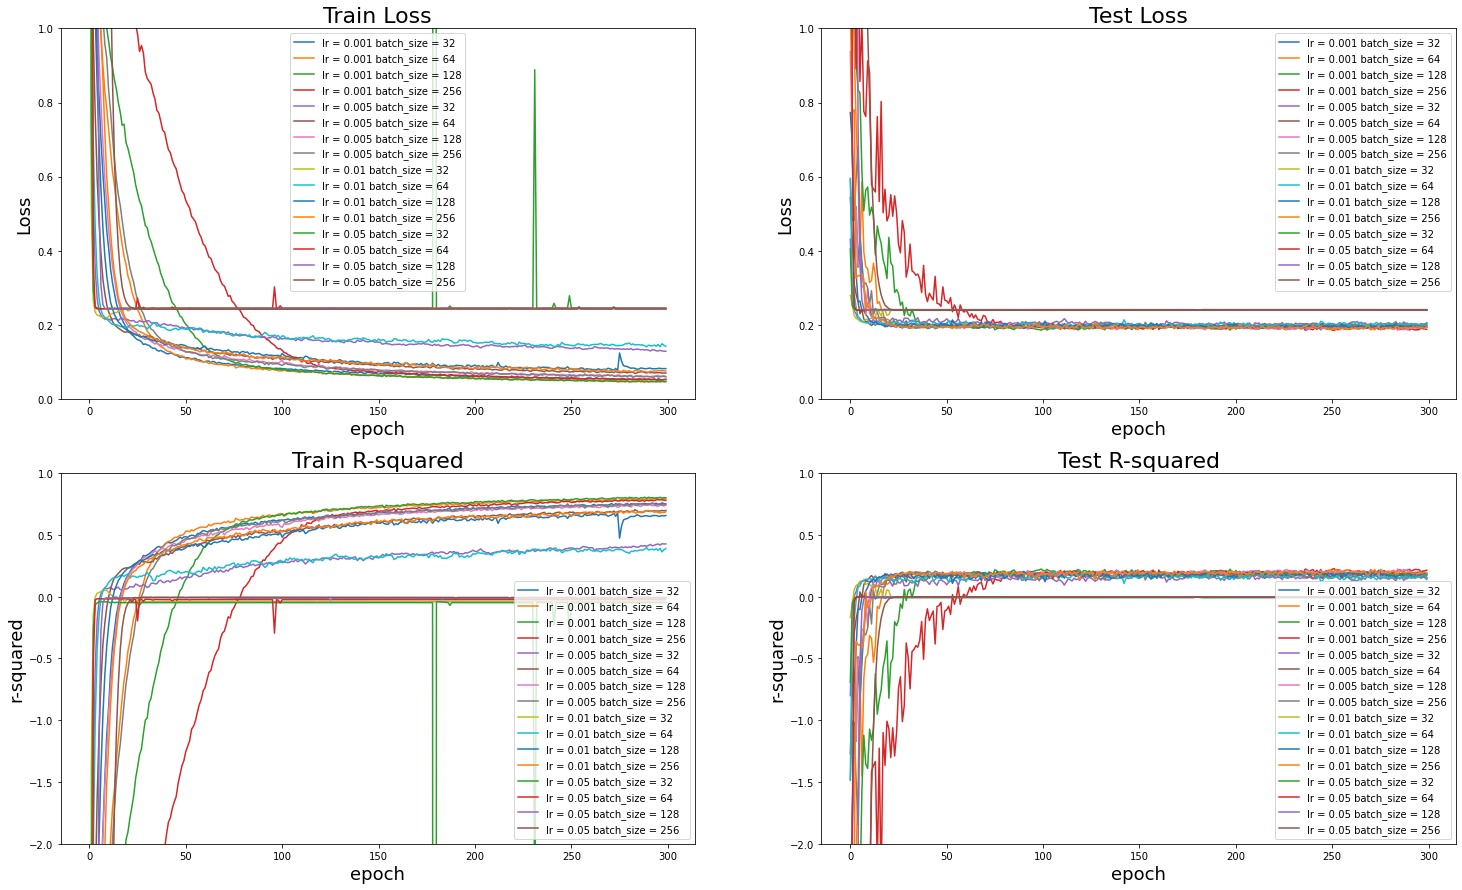

<Figure size 1800x1080 with 0 Axes>

In [17]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Train Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("Loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("Loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 1])

ax3.set_title("Train R-squared", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-2,1])

ax4.set_title("Test R-squared", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-2,1])

plt.show()

In [18]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

0.7506556513243757
0.7908964846502862
0.8007850234366845
0.7794492844753739
0.4276613947724162
0.6983409351054238
0.7409836657303378
0.7502547329572177
-0.040190979979193915
0.38971388215020675
0.6570677914857929
0.687310115838991
-0.04790567971233803
-0.024018877466247236
-0.013843374816167035
-0.005982182120474256
___________________

0.17526296583195466
0.1789717108604486
0.17837558794790487
0.2147359666693499
0.15509268351201289
0.1529821141854245
0.1916158022950053
0.13965357959261115
-0.0013178352346105981
0.14847188157602798
0.18558987336546762
0.18610454039632418
-0.007798735583401717
-0.0026972020840441147
-0.00017900803996684367
-0.0030723142623436672
___________________

0.053246753879848424
0.0480462397779628
0.04660302585493909
0.05274342826527098
0.12907510476374845
0.07006439412415245
0.06103681291650682
0.05988221210630044
0.2436832711784118
0.14256596668954297
0.08190995408561978
0.07523184059106786
0.24522008601952036
0.24473600998357103
0.2441236949967642
0.242852705

### 2 best models

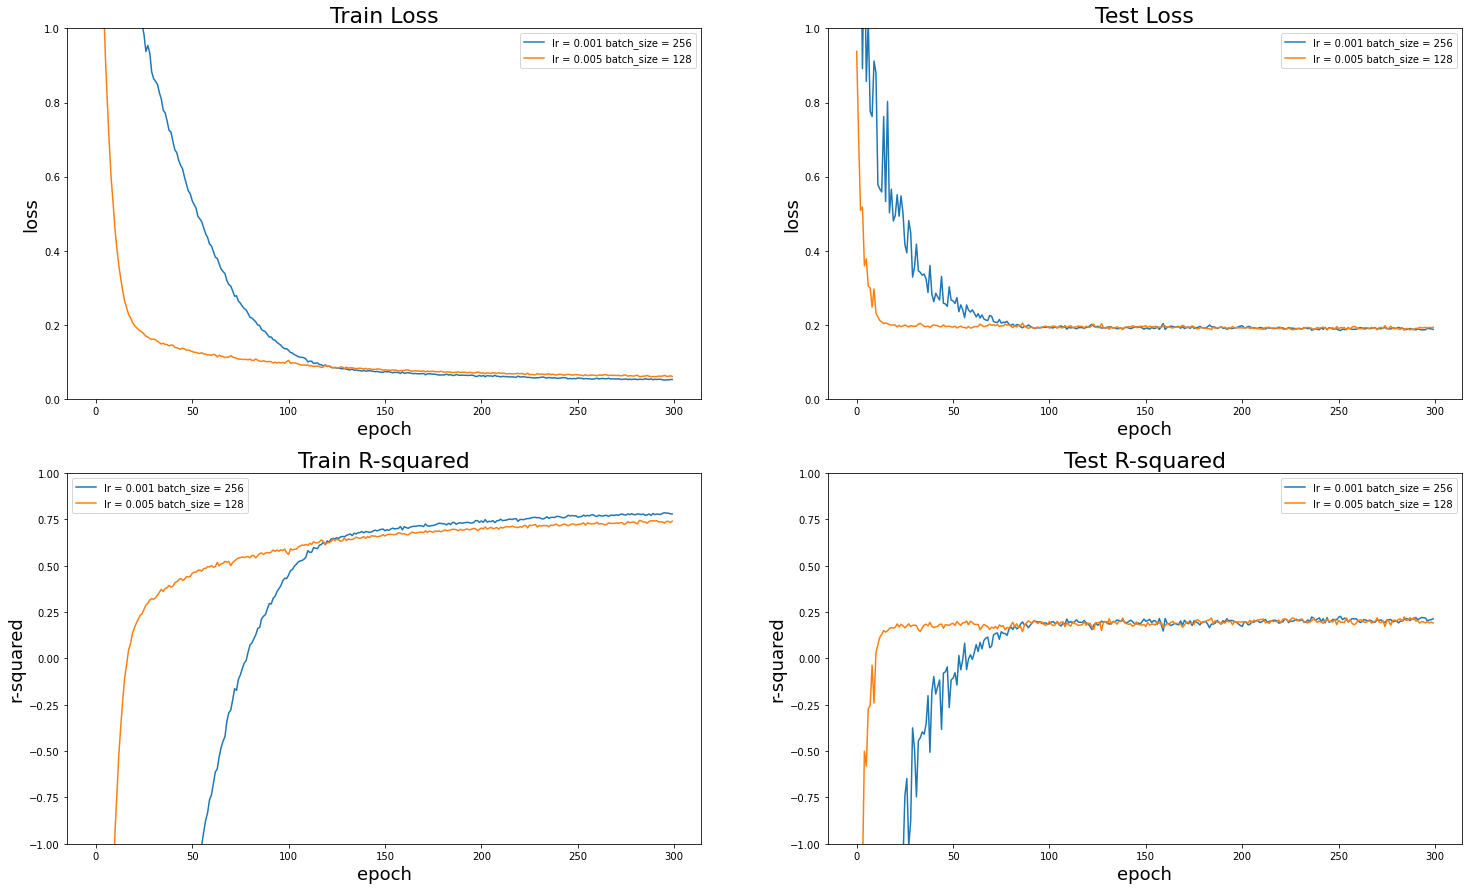

<Figure size 432x288 with 0 Axes>

In [22]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Train Loss", fontsize=22)
ax1.plot(train_losses_all[3],label="lr = 0.001 batch_size = 256")
ax1.plot(train_losses_all[6],label="lr = 0.005 batch_size = 128")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[3],label="lr = 0.001 batch_size = 256")
ax2.plot(test_losses_all[6],label="lr = 0.005 batch_size = 128")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 1])

ax3.set_title("Train R-squared", fontsize=22)
ax3.plot(train_accs_all[3],label="lr = 0.001 batch_size = 256")
ax3.plot(train_accs_all[6],label="lr = 0.005 batch_size = 128")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-1,1])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[3],label="lr = 0.001 batch_size = 256")
ax4.plot(test_accs_all[6],label="lr = 0.005 batch_size = 128")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-1,1])
plt.show()

## 4.2. Training

In [23]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=4984, shuffle=False)

In [25]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.005)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), '../../models/geno_klek_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 2.38572486776572, Accuracy: -9.064325568466861
Test Avg. loss: 0.5150890946388245, Accuracy: -1.2289782477574671
################## EPOCH 2 ##################
Train Avg. loss: 1.560356739239815, Accuracy: -5.7564235126816214
Test Avg. loss: 0.4827927350997925, Accuracy: -1.0892201709178915
################## EPOCH 3 ##################
Train Avg. loss: 1.315325522269958, Accuracy: -4.685459137610811
Test Avg. loss: 0.3558380603790283, Accuracy: -0.5398409789494081
################## EPOCH 4 ##################
Train Avg. loss: 1.0923866083224614, Accuracy: -3.701913355778199
Test Avg. loss: 0.2913844883441925, Accuracy: -0.26092673003378275
################## EPOCH 5 ##################
Train Avg. loss: 0.9284680405488381, Accuracy: -3.0002165739720956
Test Avg. loss: 0.29774701595306396, Accuracy: -0.28845976847865273
################## EPOCH 6 ##################
Train Avg. loss: 0.7487890563714199, Accuracy: -2.2034012559328

Train Avg. loss: 0.13606376563891387, Accuracy: 0.4232317920213367
Test Avg. loss: 0.19659723341464996, Accuracy: 0.14925222627326828
################## EPOCH 48 ##################
Train Avg. loss: 0.13465703398180315, Accuracy: 0.42887252425075645
Test Avg. loss: 0.19494843482971191, Accuracy: 0.15638709633263714
################## EPOCH 49 ##################
Train Avg. loss: 0.13045585265335363, Accuracy: 0.4449239988222317
Test Avg. loss: 0.19949837028980255, Accuracy: 0.13669786183124144
################## EPOCH 50 ##################
Train Avg. loss: 0.13385576324967238, Accuracy: 0.4320009840643566
Test Avg. loss: 0.19655723869800568, Accuracy: 0.1494251840497861
################## EPOCH 51 ##################
Train Avg. loss: 0.13059426681735578, Accuracy: 0.44830772734388913
Test Avg. loss: 0.1948840469121933, Accuracy: 0.15666570965405546
################## EPOCH 52 ##################
Train Avg. loss: 0.1307391738280272, Accuracy: 0.44737566249839844
Test Avg. loss: 0.1978055983

Train Avg. loss: 0.10478345553080241, Accuracy: 0.5548802370273643
Test Avg. loss: 0.19596068561077118, Accuracy: 0.15200667436093174
################## EPOCH 94 ##################
Train Avg. loss: 0.10298724847439772, Accuracy: 0.5633409126130975
Test Avg. loss: 0.19884070754051208, Accuracy: 0.13954379658448068
################## EPOCH 95 ##################
Train Avg. loss: 0.10349269144428082, Accuracy: 0.5600391470867697
Test Avg. loss: 0.19313406944274902, Accuracy: 0.1642385074090814
################## EPOCH 96 ##################
Train Avg. loss: 0.09970264299175678, Accuracy: 0.576019311047376
Test Avg. loss: 0.19946718215942383, Accuracy: 0.13683285446167914
################## EPOCH 97 ##################
Train Avg. loss: 0.10250885216280436, Accuracy: 0.5657927441924888
Test Avg. loss: 0.19770768284797668, Accuracy: 0.14444679944608374
################## EPOCH 98 ##################
Train Avg. loss: 0.10449759029329588, Accuracy: 0.5571272049038757
Test Avg. loss: 0.196227952837

Train Avg. loss: 0.08868417867387716, Accuracy: 0.6226076234333843
Test Avg. loss: 0.19428510963916779, Accuracy: 0.15925752167133966
################## EPOCH 140 ##################
Train Avg. loss: 0.08778866879546489, Accuracy: 0.627110958928248
Test Avg. loss: 0.1978965848684311, Accuracy: 0.14362933947198187
################## EPOCH 141 ##################
Train Avg. loss: 0.08728907923572339, Accuracy: 0.630161399325505
Test Avg. loss: 0.19614091515541077, Accuracy: 0.15122680822372292
################## EPOCH 142 ##################
Train Avg. loss: 0.08747548798624522, Accuracy: 0.6289088077198615
Test Avg. loss: 0.19587455689907074, Accuracy: 0.15237941369788766
################## EPOCH 143 ##################
Train Avg. loss: 0.08545396450715952, Accuracy: 0.6371309217713645
Test Avg. loss: 0.19749006628990173, Accuracy: 0.14538847984283843
################## EPOCH 144 ##################
Train Avg. loss: 0.085937962294198, Accuracy: 0.6351200511807624
Test Avg. loss: 0.1965253651

Train Avg. loss: 0.0790666985588196, Accuracy: 0.6629607528351156
Test Avg. loss: 0.19698239862918854, Accuracy: 0.14758536895044838
################## EPOCH 186 ##################
Train Avg. loss: 0.07969033536620629, Accuracy: 0.6618829139239367
Test Avg. loss: 0.19416171312332153, Accuracy: 0.15979153064187834
################## EPOCH 187 ##################
Train Avg. loss: 0.08190819867050801, Accuracy: 0.6534218957366338
Test Avg. loss: 0.19546210765838623, Accuracy: 0.15416423613232422
################## EPOCH 188 ##################
Train Avg. loss: 0.07740980241065606, Accuracy: 0.6701556810604336
Test Avg. loss: 0.19812791049480438, Accuracy: 0.14262837196238753
################## EPOCH 189 ##################
Train Avg. loss: 0.0784829963858311, Accuracy: 0.6665581975327096
Test Avg. loss: 0.19681887328624725, Accuracy: 0.1482930259198656
################## EPOCH 190 ##################
Train Avg. loss: 0.07675236043257591, Accuracy: 0.6735507503899281
Test Avg. loss: 0.20107795

Train Avg. loss: 0.07250322642712256, Accuracy: 0.693058121423914
Test Avg. loss: 0.19560487568378448, Accuracy: 0.1535464200713914
################## EPOCH 232 ##################
Train Avg. loss: 0.0750445834814738, Accuracy: 0.6841817255170862
Test Avg. loss: 0.18965810537338257, Accuracy: 0.17928030850240695
################## EPOCH 233 ##################
Train Avg. loss: 0.07474924055620646, Accuracy: 0.6837331043125109
Test Avg. loss: 0.19705024361610413, Accuracy: 0.1472917806359637
################## EPOCH 234 ##################
Train Avg. loss: 0.07226129260678323, Accuracy: 0.6936572889679475
Test Avg. loss: 0.19880488514900208, Accuracy: 0.1396988005776848
################## EPOCH 235 ##################
Train Avg. loss: 0.07403091018876204, Accuracy: 0.6868541224108212
Test Avg. loss: 0.192856103181839, Accuracy: 0.16544139258672175
################## EPOCH 236 ##################
Train Avg. loss: 0.07309225020118248, Accuracy: 0.6914579053581
Test Avg. loss: 0.200112268328666

Train Avg. loss: 0.06837421029997177, Accuracy: 0.710191855321831
Test Avg. loss: 0.19310110807418823, Accuracy: 0.1643811097322977
################## EPOCH 278 ##################
Train Avg. loss: 0.06729935245731702, Accuracy: 0.7138946849642315
Test Avg. loss: 0.20150741934776306, Accuracy: 0.12800391813058387
################## EPOCH 279 ##################
Train Avg. loss: 0.0695397965132426, Accuracy: 0.7058864426327189
Test Avg. loss: 0.18974106013774872, Accuracy: 0.17892125426481043
################## EPOCH 280 ##################
Train Avg. loss: 0.07125871332410054, Accuracy: 0.6993415252387647
Test Avg. loss: 0.19222764670848846, Accuracy: 0.16816087878433716
################## EPOCH 281 ##################
Train Avg. loss: 0.0677829689752215, Accuracy: 0.7112293265955327
Test Avg. loss: 0.19869640469551086, Accuracy: 0.14016824868553113
################## EPOCH 282 ##################
Train Avg. loss: 0.06787349063998614, Accuracy: 0.7135514258131613
Test Avg. loss: 0.197226703

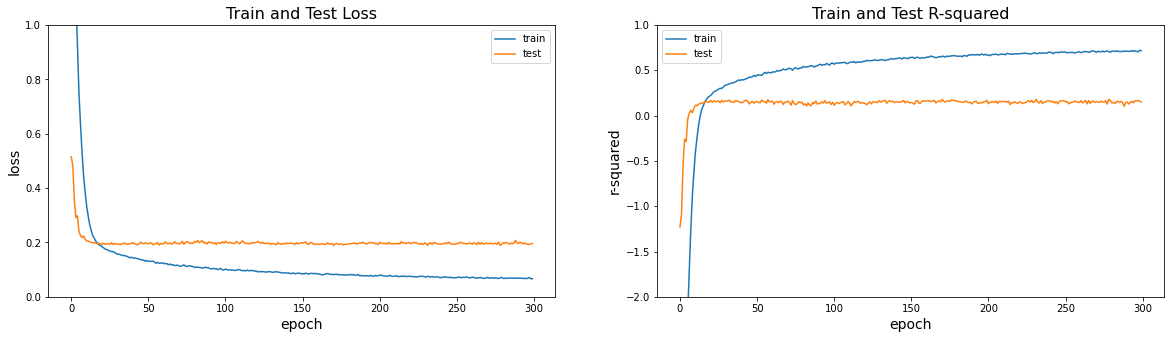

<Figure size 1440x360 with 0 Axes>

In [27]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.legend()
ax1.set_ylim([0,1])

ax2.set_title("Train and Test R-squared", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("r-squared", fontsize=14)
ax2.legend()
ax2.set_ylim([-2,1])
plt.show()

In [28]:
model = FCNN()
model.load_state_dict(torch.load('../../models/geno_klek_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 0.29769874
MSE: 0.18931286
RMSE: 0.43510097
R2 Square 0.18077429663231526 

